# Lottery Prediction

## Get Datas

In [142]:
import json
import requests
from itertools import product

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, Dropout

from tensorflow import keras
from tensorflow.keras.optimizers import Adam

In [179]:
class Lottery:

    PIYANGO = "millipiyango"
    SAYISAL = "sayisal-loto"
    SANS_TOPU = "sanstopu"
    ON_NUMARA = "onnumara"
    SUPER_LOTO = "superloto"

    GAME_LIST = [PIYANGO, SAYISAL, SANS_TOPU, ON_NUMARA, SUPER_LOTO]

    headers = {
        "Accept": "application/json, text/javascript, */*; q=0.01",
        "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/17.0 Safari/605.1.15",
        "Referer": "https://www.millipiyangoonline.com/cekilis-sonuclari/milli-piyango",
        "X-Requested-With": "XMLHttpRequest",
    }

    URL = "https://www.millipiyangoonline.com/sisalsans/result.{}.{}.{}.json"

    @staticmethod
    def process_response(resp, error_message: str) -> dict:
        if resp.ok and resp.status_code == 200:
            try:
                data = resp.json()
            except json.decoder.JSONDecodeError as jsDecodeError:
                # TODO: add proper exception handling
                data = resp.content.decode("utf-8-sig").encode("utf-8")
                data = json.loads(data)
            return data
        else:
            return {
                'error': error_message,
                'response': {
                    'code': resp.status_code,
                    'url': resp.url
                }
            }

    def get_result(self, game: str, month: str, year: str) -> dict:
        if game not in self.GAME_LIST:
            return {
                'error': f"Oyun adı parametresi {GAME_LIST} içerisinden bir değer olmalıdır.",
                'request': {'oyun_adi': game}
            }

        url = self.URL.format(game, month, year)
        response = requests.get(url=url, headers=self.headers)

        return self.process_response(response, "Bir sorun oluştu.")

    def run_process(self) -> None:
        df = pd.DataFrame()
        months = [str(i) for i in range(1, 13)]
        years = [str(i) for i in range(2020, 2024)]
        for year in years:
            for month in months:
                res = self.get_result(self.PIYANGO, month, year)
                if len(res) > 0:
                    if len(res[0]['drawNumbers']) > 0:
                        #print(res)
                        #amorti1 = [i['amortiNumber1'] for i in res]
                        res_df = pd.DataFrame({'Date': [i['drawDate'] for i in res], 
                                               'A': [i['drawNumbers'][0] for i in res], 
                                               'B': [i['drawNumbers'][1] for i in res], 
                                               'C': [i['drawNumbers'][2] for i in res], 
                                               'D': [i['drawNumbers'][3] for i in res], 
                                               'E': [i['drawNumbers'][4] for i in res], 
                                               'F': [i['drawNumbers'][5] for i in res], 
                                               'G': [int(i['drawNumbers'][6]) if 'drawNumbers' in i and len(i['drawNumbers']) > 6 else None for i in res],
                                               'A1': [int(i['amortiNumber1']) for i in res], 
                                               'A2': [int(i['amortiNumber2']) for i in res]})
                        df = pd.concat([df, res_df], ignore_index=True)
        return df
        #print(df.to_string())

In [180]:
df = Lottery().run_process()

## Analysis

In [181]:
df.head()

,Date,A,B,C,D,E,F,G,A1,A2
0,08/09/2020,2,9,0,6,1,1,None,1,6
1,08/19/2020,5,6,2,2,1,9,None,4,9
2,08/30/2020,4,0,2,5,9,8,None,2,7
3,09/09/2020,6,1,7,3,6,6,None,0,5
4,09/19/2020,1,6,5,7,5,5,None,2,6


In [182]:
df.tail()

,Date,A,B,C,D,E,F,G,A1,A2
72,09/29/2023,2,9,4,7,8,2,None,4,7
73,10/09/2023,3,3,5,3,9,6,NaN,2,9
74,10/29/2023,1,0,4,6,1,6,5.0,0,7
75,11/09/2023,0,6,5,9,0,4,None,3,7
76,12/31/2023,3,5,5,0,0,5,4,2,7


## Visualization

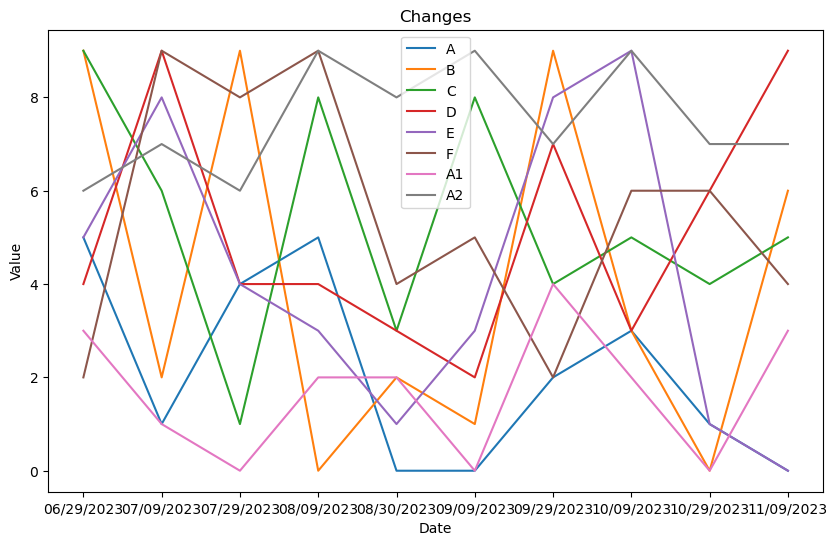

In [183]:
plt.figure(figsize=(10, 6))
plt.plot(df['Date'][66:76], df['A'][66:76], label='A')
plt.plot(df['Date'][66:76], df['B'][66:76], label='B')
plt.plot(df['Date'][66:76], df['C'][66:76], label='C')
plt.plot(df['Date'][66:76], df['D'][66:76], label='D')
plt.plot(df['Date'][66:76], df['E'][66:76], label='E')
plt.plot(df['Date'][66:76], df['F'][66:76], label='F')
#plt.plot(df['Date'], df['G'], label='G')
plt.plot(df['Date'][66:76], df['A1'][66:76], label='A1')
plt.plot(df['Date'][66:76], df['A2'][66:76], label='A2')

plt.title('Changes')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

**There is a random distribution**

In [184]:
print(df.shape)

(77, 10)


In [185]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    77 non-null     object
 1   A       77 non-null     int64 
 2   B       77 non-null     int64 
 3   C       77 non-null     int64 
 4   D       77 non-null     int64 
 5   E       77 non-null     int64 
 6   F       77 non-null     int64 
 7   G       18 non-null     object
 8   A1      77 non-null     int64 
 9   A2      77 non-null     int64 
dtypes: int64(8), object(2)
memory usage: 6.1+ KB


In [186]:
df.describe()

,A,B,C,D,E,F,A1,A2
count,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,2.740260,4.636364,4.051948,4.389610,4.467532,4.922078,1.961039,6.805195
std,2.607694,3.051786,2.595016,2.570868,2.886376,2.713350,1.454951,1.235856
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
25%,1.000000,2.000000,2.000000,3.000000,2.000000,3.000000,1.000000,6.000000
50%,2.000000,5.000000,4.000000,4.000000,4.000000,5.000000,2.000000,7.000000
75%,5.000000,7.000000,6.000000,6.000000,7.000000,7.000000,3.000000,8.000000
max,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,4.000000,9.000000


In [187]:
data = df.copy()
data.drop(['Date', 'G'], axis=1, inplace=True)
data.head()

,A,B,C,D,E,F,A1,A2
0,2,9,0,6,1,1,1,6
1,5,6,2,2,1,9,4,9
2,4,0,2,5,9,8,2,7
3,6,1,7,3,6,6,0,5
4,1,6,5,7,5,5,2,6


In [188]:
scaler = StandardScaler().fit(data.values)
transformed_dataset = scaler.transform(data.values)
transformed_df = pd.DataFrame(data=transformed_dataset, index=data.index)

In [189]:
transformed_df.head()

,0,1,2,3,4,5,6,7
0,-0.285737,1.439239,-1.571674,0.630507,-1.209222,-1.454953,-0.664861,-0.655800
1,0.872249,0.449762,-0.795912,-0.935591,-1.209222,1.512766,1.410584,1.787584
2,0.486254,-1.529192,-0.795912,0.238982,1.580594,1.141801,0.026954,0.158661
3,1.258244,-1.199366,1.143493,-0.544066,0.534413,0.399871,-1.356677,-1.470262
4,-0.671732,0.449762,0.367731,1.022031,0.185686,0.028906,0.026954,-0.655800


In [190]:
# All our games
number_of_rows = data.values.shape[0]
number_of_rows

77

In [191]:
# Balls counts
number_of_features = data.values.shape[1]
number_of_features

8

In [192]:
window_length = 7
window_length

7

In [193]:
X = np.empty([ number_of_rows - window_length, window_length, number_of_features], dtype=float)
y = np.empty([ number_of_rows - window_length, number_of_features], dtype=float)
for i in range(0, number_of_rows-window_length):
    X[i] = transformed_df.iloc[i : i+window_length, 0 : number_of_features]
    y[i] = transformed_df.iloc[i+window_length : i+window_length+1, 0 : number_of_features]

In [194]:
X.shape

(70, 7, 8)

In [195]:
y.shape

(70, 8)

In [196]:
X[0]

array([[-0.28573672,  1.43923946, -1.57167374,  0.63050666, -1.20922226,
        -1.4549529 , -0.6648614 , -0.65580015],
       [ 0.87224894,  0.44976233, -0.7959117 , -0.93559053, -1.20922226,
         1.5127656 ,  1.41058433,  1.78758429],
       [ 0.48625372, -1.52919193, -0.7959117 ,  0.23898236,  1.5805939 ,
         1.14180079,  0.02695384,  0.15866133],
       [ 1.25824416, -1.19936622,  1.14349339, -0.54406623,  0.53441284,
         0.39987116, -1.35667665, -1.47026164],
       [-0.67173194,  0.44976233,  0.36773136,  1.02203096,  0.18568582,
         0.02890635,  0.02695384, -0.65580015],
       [ 1.25824416, -1.52919193, -1.57167374, -0.93559053, -0.86049524,
         1.14180079,  0.02695384, -0.65580015],
       [-1.05772716,  0.44976233,  0.36773136,  0.63050666, -1.55794928,
         1.14180079, -0.6648614 , -0.65580015]])

In [197]:
y[0]

array([-0.67173194,  1.10941375,  0.75561237,  0.23898236, -0.51176822,
        1.5127656 , -0.6648614 , -1.47026164])

In [198]:
X[1]

array([[ 0.87224894,  0.44976233, -0.7959117 , -0.93559053, -1.20922226,
         1.5127656 ,  1.41058433,  1.78758429],
       [ 0.48625372, -1.52919193, -0.7959117 ,  0.23898236,  1.5805939 ,
         1.14180079,  0.02695384,  0.15866133],
       [ 1.25824416, -1.19936622,  1.14349339, -0.54406623,  0.53441284,
         0.39987116, -1.35667665, -1.47026164],
       [-0.67173194,  0.44976233,  0.36773136,  1.02203096,  0.18568582,
         0.02890635,  0.02695384, -0.65580015],
       [ 1.25824416, -1.52919193, -1.57167374, -0.93559053, -0.86049524,
         1.14180079,  0.02695384, -0.65580015],
       [-1.05772716,  0.44976233,  0.36773136,  0.63050666, -1.55794928,
         1.14180079, -0.6648614 , -0.65580015],
       [-0.67173194,  1.10941375,  0.75561237,  0.23898236, -0.51176822,
         1.5127656 , -0.6648614 , -1.47026164]])

In [199]:
y[1]

array([-0.67173194,  0.44976233,  1.14349339,  1.41355526,  1.5805939 ,
        0.02890635, -1.35667665, -0.65580015])

## Train and Test Split

In [200]:
# Assuming X and y are your features and labels, respectively
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

# If you have already created X and y, you can use the train_test_split function to split them
# The test_size parameter controls the ratio of the validation set (0.2 means 20% validation, 80% training)

# Print the shapes to verify the split
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (56, 7, 8)
y_train shape: (56, 8)
X_val shape: (14, 7, 8)
y_val shape: (14, 8)


## Modelling

In [201]:
def build_and_train_model(learning_rate, dropout_rate, lstm_unit, window_length, epoch, batch_size):
    model = Sequential()
    model.add(Bidirectional(LSTM(lstm_unit, input_shape=(window_length, number_of_features), return_sequences=True)))
    model.add(Dropout(dropout_rate))
    model.add(Bidirectional(LSTM(lstm_unit, input_shape=(window_length, number_of_features), return_sequences=True)))
    model.add(Dropout(dropout_rate))
    model.add(Bidirectional(LSTM(lstm_unit, input_shape=(window_length, number_of_features), return_sequences=True)))
    model.add(Bidirectional(LSTM(lstm_unit, input_shape=(window_length, number_of_features), return_sequences=False)))
    model.add(Dense(59))
    model.add(Dense(number_of_features))
    
    # Compile the model (replace optimizer and loss with your specific settings)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss ='mse', metrics=['accuracy'])
    
    # Train the model (replace X_train, y_train, validation_data with your specific data)
    model.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, validation_data=(X_val, y_val))
    
    # Evaluate the model on the validation set (replace X_val, y_val with your specific data)
    score = model.evaluate(X_val, y_val)
    
    return score  # Return the metric you want to optimize (e.g., validation loss)

In [202]:
# Define the hyperparameter ranges
learning_rates = [0.0001]
dropout_rates = [0.2, 0.4, 0.6]
lstm_units_list = [120, 240]
window_lengths = [7]
epochs = [32, 64, 100, 128, 240]
batch_sizes = [100, 300, 400, 500]

# Perform grid search
best_score = float('inf')  # Assuming we want to minimize the metric
best_params = None

for learning_rate, dropout_rate, lstm_unit, window_length, epoch, batch_size in product(learning_rates, dropout_rates, lstm_units_list, window_lengths, epochs, batch_sizes):
    scores = build_and_train_model(learning_rate, dropout_rate, lstm_unit, window_length, epoch, batch_size)
    print(f'Parameters: lr={learning_rate}, dropout={dropout_rate}, lstm_units={lstm_unit}, wl= {window_length}, epoch={epoch}, batch_size={batch_size}, Scores: {scores}')
    accuracy_score = scores[1]
    print(f'Accuracy on validation set: {accuracy_score}')
    loss_value = scores[0]
    print(f'Loss on validation set: {loss_value}')
    if accuracy_score < best_score:  # Assuming score[0] is the validation loss
        best_score = accuracy_score
        best_params = {'learning_rate': learning_rate, 'dropout_rate': dropout_rate, 'lstm_unit': lstm_unit, 'window_length': window_length, 'epoch': epoch, 'batch_size': batch_size}

print(f'Best Parameters: {best_params}, Best Score: {best_score}')

Epoch 1/32
1/1 [==============================] - 6s 6s/step - loss: 0.9863 - accuracy: 0.0714 - val_loss: 1.0655 - val_accuracy: 0.2143
Epoch 2/32
1/1 [==============================] - 0s 130ms/step - loss: 0.9830 - accuracy: 0.0893 - val_loss: 1.0655 - val_accuracy: 0.0714
Epoch 3/32
1/1 [==============================] - 0s 292ms/step - loss: 0.9811 - accuracy: 0.0536 - val_loss: 1.0655 - val_accuracy: 0.0714
Epoch 4/32
1/1 [==============================] - 0s 257ms/step - loss: 0.9791 - accuracy: 0.1786 - val_loss: 1.0656 - val_accuracy: 0.0000e+00
Epoch 5/32
1/1 [==============================] - 0s 144ms/step - loss: 0.9767 - accuracy: 0.1964 - val_loss: 1.0656 - val_accuracy: 0.0000e+00
Epoch 6/32
1/1 [==============================] - 0s 157ms/step - loss: 0.9728 - accuracy: 0.2321 - val_loss: 1.0657 - val_accuracy: 0.0000e+00
Epoch 7/32
1/1 [==============================] - 0s 165ms/step - loss: 0.9718 - accuracy: 0.2679 - val_loss: 1.0658 - val_accuracy: 0.0714
Epoch 8/32


Epoch 1/32
1/1 [==============================] - 5s 5s/step - loss: 0.9868 - accuracy: 0.1071 - val_loss: 1.0668 - val_accuracy: 0.2857
Epoch 2/32
1/1 [==============================] - 0s 120ms/step - loss: 0.9853 - accuracy: 0.1429 - val_loss: 1.0671 - val_accuracy: 0.2857
Epoch 3/32
1/1 [==============================] - 0s 212ms/step - loss: 0.9824 - accuracy: 0.1964 - val_loss: 1.0673 - val_accuracy: 0.3571
Epoch 4/32
1/1 [==============================] - 0s 193ms/step - loss: 0.9797 - accuracy: 0.2321 - val_loss: 1.0675 - val_accuracy: 0.2857
Epoch 5/32
1/1 [==============================] - 0s 202ms/step - loss: 0.9785 - accuracy: 0.2679 - val_loss: 1.0677 - val_accuracy: 0.2143
Epoch 6/32
1/1 [==============================] - 0s 189ms/step - loss: 0.9748 - accuracy: 0.3571 - val_loss: 1.0680 - val_accuracy: 0.2143
Epoch 7/32
1/1 [==============================] - 0s 140ms/step - loss: 0.9724 - accuracy: 0.3750 - val_loss: 1.0683 - val_accuracy: 0.2143
Epoch 8/32
1/1 [=======

Parameters: lr=0.0001, dropout=0.2, lstm_units=120, wl= 7, epoch=32, batch_size=300, Scores: [1.0755412578582764, 0.2142857164144516]
Accuracy on validation set: 0.2142857164144516
Loss on validation set: 1.0755412578582764


Epoch 1/32
1/1 [==============================] - 5s 5s/step - loss: 0.9816 - accuracy: 0.1964 - val_loss: 1.0726 - val_accuracy: 0.2143
Epoch 2/32
1/1 [==============================] - 0s 168ms/step - loss: 0.9802 - accuracy: 0.2321 - val_loss: 1.0734 - val_accuracy: 0.2143
Epoch 3/32
1/1 [==============================] - 0s 120ms/step - loss: 0.9784 - accuracy: 0.1964 - val_loss: 1.0743 - val_accuracy: 0.2143
Epoch 4/32
1/1 [==============================] - 0s 150ms/step - loss: 0.9755 - accuracy: 0.2857 - val_loss: 1.0751 - val_accuracy: 0.2143
Epoch 5/32
1/1 [==============================] - 0s 163ms/step - loss: 0.9743 - accuracy: 0.2321 - val_loss: 1.0761 - val_accuracy: 0.2143
Epoch 6/32
1/1 [==============================] - 0s 130ms/step - loss: 0.9723 - accuracy: 0.3036 - val_loss: 1.0770 - val_accuracy: 0.2143
Epoch 7/32
1/1 [==============================] - 0s 193ms/step - loss: 0.9704 - accuracy: 0.2679 - val_loss: 1.0779 - val_accuracy: 0.2857
Epoch 8/32
1/1 [=======

Parameters: lr=0.0001, dropout=0.2, lstm_units=120, wl= 7, epoch=32, batch_size=400, Scores: [1.113624930381775, 0.2857142984867096]
Accuracy on validation set: 0.2857142984867096
Loss on validation set: 1.113624930381775
Epoch 1/32
1/1 [==============================] - 6s 6s/step - loss: 0.9858 - accuracy: 0.0714 - val_loss: 1.0750 - val_accuracy: 0.0000e+00
Epoch 2/32
1/1 [==============================] - 0s 167ms/step - loss: 0.9821 - accuracy: 0.1250 - val_loss: 1.0755 - val_accuracy: 0.0000e+00
Epoch 3/32
1/1 [==============================] - 0s 177ms/step - loss: 0.9818 - accuracy: 0.1071 - val_loss: 1.0761 - val_accuracy: 0.0714
Epoch 4/32
1/1 [==============================] - 0s 179ms/step - loss: 0.9780 - accuracy: 0.0893 - val_loss: 1.0767 - val_accuracy: 0.1429
Epoch 5/32
1/1 [==============================] - 0s 176ms/step - loss: 0.9769 - accuracy: 0.1786 - val_loss: 1.0773 - val_accuracy: 0.1429
Epoch 6/32
1/1 [==============================] - 0s 168ms/step - loss: 0

Parameters: lr=0.0001, dropout=0.2, lstm_units=120, wl= 7, epoch=32, batch_size=500, Scores: [1.1019634008407593, 0.0714285746216774]
Accuracy on validation set: 0.0714285746216774
Loss on validation set: 1.1019634008407593


Epoch 1/64
1/1 [==============================] - 6s 6s/step - loss: 0.9850 - accuracy: 0.0893 - val_loss: 1.0702 - val_accuracy: 0.2143
Epoch 2/64
1/1 [==============================] - 0s 170ms/step - loss: 0.9824 - accuracy: 0.1250 - val_loss: 1.0707 - val_accuracy: 0.2143
Epoch 3/64
1/1 [==============================] - 0s 173ms/step - loss: 0.9809 - accuracy: 0.1786 - val_loss: 1.0712 - val_accuracy: 0.2143
Epoch 4/64
1/1 [==============================] - 0s 132ms/step - loss: 0.9789 - accuracy: 0.1429 - val_loss: 1.0717 - val_accuracy: 0.1429
Epoch 5/64
1/1 [==============================] - 0s 164ms/step - loss: 0.9764 - accuracy: 0.1786 - val_loss: 1.0722 - val_accuracy: 0.1429
Epoch 6/64
1/1 [==============================] - 0s 149ms/step - loss: 0.9751 - accuracy: 0.1786 - val_loss: 1.0727 - val_accuracy: 0.2143
Epoch 7/64
1/1 [==============================] - 0s 119ms/step - loss: 0.9723 - accuracy: 0.2679 - val_loss: 1.0732 - val_accuracy: 0.2143
Epoch 8/64
1/1 [=======

Parameters: lr=0.0001, dropout=0.2, lstm_units=120, wl= 7, epoch=64, batch_size=100, Scores: [1.1981345415115356, 0.1428571492433548]
Accuracy on validation set: 0.1428571492433548
Loss on validation set: 1.1981345415115356


Epoch 1/64
1/1 [==============================] - 5s 5s/step - loss: 0.9837 - accuracy: 0.1250 - val_loss: 1.0689 - val_accuracy: 0.0000e+00
Epoch 2/64
1/1 [==============================] - 0s 169ms/step - loss: 0.9811 - accuracy: 0.1786 - val_loss: 1.0696 - val_accuracy: 0.0000e+00
Epoch 3/64
1/1 [==============================] - 0s 173ms/step - loss: 0.9794 - accuracy: 0.2143 - val_loss: 1.0702 - val_accuracy: 0.0000e+00
Epoch 4/64
1/1 [==============================] - 0s 181ms/step - loss: 0.9770 - accuracy: 0.2500 - val_loss: 1.0709 - val_accuracy: 0.0000e+00
Epoch 5/64
1/1 [==============================] - 0s 169ms/step - loss: 0.9750 - accuracy: 0.3393 - val_loss: 1.0716 - val_accuracy: 0.0714
Epoch 6/64
1/1 [==============================] - 0s 130ms/step - loss: 0.9720 - accuracy: 0.3036 - val_loss: 1.0723 - val_accuracy: 0.0714
Epoch 7/64
1/1 [==============================] - 0s 182ms/step - loss: 0.9701 - accuracy: 0.3214 - val_loss: 1.0730 - val_accuracy: 0.0714
Epoch 8

Parameters: lr=0.0001, dropout=0.2, lstm_units=120, wl= 7, epoch=64, batch_size=300, Scores: [1.1797876358032227, 0.1428571492433548]
Accuracy on validation set: 0.1428571492433548
Loss on validation set: 1.1797876358032227


Epoch 1/64
1/1 [==============================] - 5s 5s/step - loss: 0.9853 - accuracy: 0.0714 - val_loss: 1.0746 - val_accuracy: 0.0714
Epoch 2/64
1/1 [==============================] - 0s 172ms/step - loss: 0.9828 - accuracy: 0.1071 - val_loss: 1.0749 - val_accuracy: 0.0714
Epoch 3/64
1/1 [==============================] - 0s 161ms/step - loss: 0.9814 - accuracy: 0.1607 - val_loss: 1.0753 - val_accuracy: 0.0000e+00
Epoch 4/64
1/1 [==============================] - 0s 166ms/step - loss: 0.9789 - accuracy: 0.1786 - val_loss: 1.0757 - val_accuracy: 0.0000e+00
Epoch 5/64
1/1 [==============================] - 0s 173ms/step - loss: 0.9759 - accuracy: 0.1607 - val_loss: 1.0760 - val_accuracy: 0.0714
Epoch 6/64
1/1 [==============================] - 0s 192ms/step - loss: 0.9742 - accuracy: 0.1964 - val_loss: 1.0765 - val_accuracy: 0.0714
Epoch 7/64
1/1 [==============================] - 0s 131ms/step - loss: 0.9720 - accuracy: 0.2143 - val_loss: 1.0769 - val_accuracy: 0.0714
Epoch 8/64
1/1 

Parameters: lr=0.0001, dropout=0.2, lstm_units=120, wl= 7, epoch=64, batch_size=400, Scores: [1.1866751909255981, 0.0714285746216774]
Accuracy on validation set: 0.0714285746216774
Loss on validation set: 1.1866751909255981
Epoch 1/64
1/1 [==============================] - 5s 5s/step - loss: 0.9814 - accuracy: 0.1429 - val_loss: 1.0698 - val_accuracy: 0.0000e+00
Epoch 2/64
1/1 [==============================] - 0s 120ms/step - loss: 0.9804 - accuracy: 0.1250 - val_loss: 1.0701 - val_accuracy: 0.0000e+00
Epoch 3/64
1/1 [==============================] - 0s 190ms/step - loss: 0.9779 - accuracy: 0.2143 - val_loss: 1.0704 - val_accuracy: 0.0714
Epoch 4/64
1/1 [==============================] - 0s 180ms/step - loss: 0.9749 - accuracy: 0.2143 - val_loss: 1.0708 - val_accuracy: 0.0714
Epoch 5/64
1/1 [==============================] - 0s 168ms/step - loss: 0.9734 - accuracy: 0.2143 - val_loss: 1.0711 - val_accuracy: 0.0000e+00
Epoch 6/64
1/1 [==============================] - 0s 124ms/step - l

Parameters: lr=0.0001, dropout=0.2, lstm_units=120, wl= 7, epoch=64, batch_size=500, Scores: [1.2087420225143433, 0.1428571492433548]
Accuracy on validation set: 0.1428571492433548
Loss on validation set: 1.2087420225143433


Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 0.9858 - accuracy: 0.0893 - val_loss: 1.0729 - val_accuracy: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 0s 124ms/step - loss: 0.9831 - accuracy: 0.1250 - val_loss: 1.0735 - val_accuracy: 0.0000e+00
Epoch 3/100
1/1 [==============================] - 0s 117ms/step - loss: 0.9803 - accuracy: 0.1786 - val_loss: 1.0742 - val_accuracy: 0.0000e+00
Epoch 4/100
1/1 [==============================] - 0s 213ms/step - loss: 0.9801 - accuracy: 0.1964 - val_loss: 1.0749 - val_accuracy: 0.0000e+00
Epoch 5/100
1/1 [==============================] - 0s 131ms/step - loss: 0.9781 - accuracy: 0.1964 - val_loss: 1.0756 - val_accuracy: 0.0000e+00
Epoch 6/100
1/1 [==============================] - 0s 167ms/step - loss: 0.9758 - accuracy: 0.1964 - val_loss: 1.0764 - val_accuracy: 0.0000e+00
Epoch 7/100
1/1 [==============================] - 0s 184ms/step - loss: 0.9726 - accuracy: 0.1607 - val_loss: 1.0772 - val_accuracy:

Parameters: lr=0.0001, dropout=0.2, lstm_units=120, wl= 7, epoch=100, batch_size=100, Scores: [1.342293381690979, 0.0714285746216774]
Accuracy on validation set: 0.0714285746216774
Loss on validation set: 1.342293381690979


Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 0.9846 - accuracy: 0.1250 - val_loss: 1.0739 - val_accuracy: 0.2857
Epoch 2/100
1/1 [==============================] - 0s 164ms/step - loss: 0.9831 - accuracy: 0.1429 - val_loss: 1.0747 - val_accuracy: 0.2857
Epoch 3/100
1/1 [==============================] - 0s 176ms/step - loss: 0.9800 - accuracy: 0.1071 - val_loss: 1.0757 - val_accuracy: 0.1429
Epoch 4/100
1/1 [==============================] - 0s 166ms/step - loss: 0.9766 - accuracy: 0.1429 - val_loss: 1.0766 - val_accuracy: 0.0714
Epoch 5/100
1/1 [==============================] - 0s 172ms/step - loss: 0.9744 - accuracy: 0.1607 - val_loss: 1.0776 - val_accuracy: 0.0714
Epoch 6/100
1/1 [==============================] - 0s 170ms/step - loss: 0.9730 - accuracy: 0.2143 - val_loss: 1.0786 - val_accuracy: 0.0714
Epoch 7/100
1/1 [==============================] - 0s 173ms/step - loss: 0.9691 - accuracy: 0.2321 - val_loss: 1.0796 - val_accuracy: 0.0714
Epoch 8/100
1/1 

Parameters: lr=0.0001, dropout=0.2, lstm_units=120, wl= 7, epoch=100, batch_size=300, Scores: [1.3429707288742065, 0.1428571492433548]
Accuracy on validation set: 0.1428571492433548
Loss on validation set: 1.3429707288742065


Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 0.9839 - accuracy: 0.1429 - val_loss: 1.0669 - val_accuracy: 0.0714
Epoch 2/100
1/1 [==============================] - 0s 164ms/step - loss: 0.9801 - accuracy: 0.1786 - val_loss: 1.0673 - val_accuracy: 0.0714
Epoch 3/100
1/1 [==============================] - 0s 171ms/step - loss: 0.9778 - accuracy: 0.1964 - val_loss: 1.0677 - val_accuracy: 0.0714
Epoch 4/100
1/1 [==============================] - 0s 174ms/step - loss: 0.9767 - accuracy: 0.2143 - val_loss: 1.0682 - val_accuracy: 0.0714
Epoch 5/100
1/1 [==============================] - 0s 179ms/step - loss: 0.9733 - accuracy: 0.3036 - val_loss: 1.0686 - val_accuracy: 0.0714
Epoch 6/100
1/1 [==============================] - 0s 168ms/step - loss: 0.9715 - accuracy: 0.2321 - val_loss: 1.0691 - val_accuracy: 0.0714
Epoch 7/100
1/1 [==============================] - 0s 170ms/step - loss: 0.9703 - accuracy: 0.2857 - val_loss: 1.0695 - val_accuracy: 0.1429
Epoch 8/100
1/1 

Parameters: lr=0.0001, dropout=0.2, lstm_units=120, wl= 7, epoch=100, batch_size=400, Scores: [1.290684700012207, 0.1428571492433548]
Accuracy on validation set: 0.1428571492433548
Loss on validation set: 1.290684700012207


Epoch 1/100
1/1 [==============================] - 6s 6s/step - loss: 0.9843 - accuracy: 0.0714 - val_loss: 1.0708 - val_accuracy: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 0s 112ms/step - loss: 0.9813 - accuracy: 0.1071 - val_loss: 1.0714 - val_accuracy: 0.0000e+00
Epoch 3/100
1/1 [==============================] - 0s 119ms/step - loss: 0.9800 - accuracy: 0.1071 - val_loss: 1.0720 - val_accuracy: 0.0714
Epoch 4/100
1/1 [==============================] - 0s 223ms/step - loss: 0.9773 - accuracy: 0.1250 - val_loss: 1.0725 - val_accuracy: 0.0714
Epoch 5/100
1/1 [==============================] - 0s 183ms/step - loss: 0.9754 - accuracy: 0.1964 - val_loss: 1.0731 - val_accuracy: 0.0714
Epoch 6/100
1/1 [==============================] - 0s 130ms/step - loss: 0.9724 - accuracy: 0.2143 - val_loss: 1.0738 - val_accuracy: 0.0714
Epoch 7/100
1/1 [==============================] - 0s 125ms/step - loss: 0.9695 - accuracy: 0.2143 - val_loss: 1.0744 - val_accuracy: 0.0714
Epoch 8/

Parameters: lr=0.0001, dropout=0.2, lstm_units=120, wl= 7, epoch=100, batch_size=500, Scores: [1.2591485977172852, 0.1428571492433548]
Accuracy on validation set: 0.1428571492433548
Loss on validation set: 1.2591485977172852


Epoch 1/128
1/1 [==============================] - 6s 6s/step - loss: 0.9793 - accuracy: 0.1429 - val_loss: 1.0702 - val_accuracy: 0.2143
Epoch 2/128
1/1 [==============================] - 0s 163ms/step - loss: 0.9777 - accuracy: 0.1964 - val_loss: 1.0709 - val_accuracy: 0.2143
Epoch 3/128
1/1 [==============================] - 0s 174ms/step - loss: 0.9750 - accuracy: 0.2679 - val_loss: 1.0717 - val_accuracy: 0.2143
Epoch 4/128
1/1 [==============================] - 0s 170ms/step - loss: 0.9740 - accuracy: 0.2679 - val_loss: 1.0724 - val_accuracy: 0.2143
Epoch 5/128
1/1 [==============================] - 0s 155ms/step - loss: 0.9710 - accuracy: 0.2500 - val_loss: 1.0732 - val_accuracy: 0.2143
Epoch 6/128
1/1 [==============================] - 0s 125ms/step - loss: 0.9695 - accuracy: 0.2321 - val_loss: 1.0740 - val_accuracy: 0.1429
Epoch 7/128
1/1 [==============================] - 0s 135ms/step - loss: 0.9672 - accuracy: 0.1964 - val_loss: 1.0748 - val_accuracy: 0.1429
Epoch 8/128
1/1 

Parameters: lr=0.0001, dropout=0.2, lstm_units=120, wl= 7, epoch=128, batch_size=100, Scores: [1.4560188055038452, 0.0]
Accuracy on validation set: 0.0
Loss on validation set: 1.4560188055038452


Epoch 1/128
1/1 [==============================] - 5s 5s/step - loss: 0.9838 - accuracy: 0.0893 - val_loss: 1.0729 - val_accuracy: 0.0000e+00
Epoch 2/128
1/1 [==============================] - 0s 113ms/step - loss: 0.9814 - accuracy: 0.1250 - val_loss: 1.0731 - val_accuracy: 0.0000e+00
Epoch 3/128
1/1 [==============================] - 0s 207ms/step - loss: 0.9794 - accuracy: 0.1250 - val_loss: 1.0734 - val_accuracy: 0.0714
Epoch 4/128
1/1 [==============================] - 0s 168ms/step - loss: 0.9765 - accuracy: 0.1786 - val_loss: 1.0737 - val_accuracy: 0.0714
Epoch 5/128
1/1 [==============================] - 0s 167ms/step - loss: 0.9749 - accuracy: 0.1607 - val_loss: 1.0740 - val_accuracy: 0.0714
Epoch 6/128
1/1 [==============================] - 0s 170ms/step - loss: 0.9734 - accuracy: 0.1964 - val_loss: 1.0743 - val_accuracy: 0.0714
Epoch 7/128
1/1 [==============================] - 0s 121ms/step - loss: 0.9704 - accuracy: 0.2143 - val_loss: 1.0746 - val_accuracy: 0.0714
Epoch 8/

Parameters: lr=0.0001, dropout=0.2, lstm_units=120, wl= 7, epoch=128, batch_size=300, Scores: [1.4170774221420288, 0.2142857164144516]
Accuracy on validation set: 0.2142857164144516
Loss on validation set: 1.4170774221420288


Epoch 1/128
1/1 [==============================] - 5s 5s/step - loss: 0.9822 - accuracy: 0.1071 - val_loss: 1.0729 - val_accuracy: 0.0000e+00
Epoch 2/128
1/1 [==============================] - 0s 164ms/step - loss: 0.9810 - accuracy: 0.1786 - val_loss: 1.0732 - val_accuracy: 0.0000e+00
Epoch 3/128
1/1 [==============================] - 0s 164ms/step - loss: 0.9781 - accuracy: 0.1964 - val_loss: 1.0736 - val_accuracy: 0.0000e+00
Epoch 4/128
1/1 [==============================] - 0s 133ms/step - loss: 0.9751 - accuracy: 0.2321 - val_loss: 1.0739 - val_accuracy: 0.1429
Epoch 5/128
1/1 [==============================] - 0s 132ms/step - loss: 0.9737 - accuracy: 0.2143 - val_loss: 1.0742 - val_accuracy: 0.1429
Epoch 6/128
1/1 [==============================] - 0s 115ms/step - loss: 0.9717 - accuracy: 0.2679 - val_loss: 1.0746 - val_accuracy: 0.1429
Epoch 7/128
1/1 [==============================] - 1s 597ms/step - loss: 0.9694 - accuracy: 0.2857 - val_loss: 1.0749 - val_accuracy: 0.1429
Epoc

Parameters: lr=0.0001, dropout=0.2, lstm_units=120, wl= 7, epoch=128, batch_size=400, Scores: [1.3986760377883911, 0.0714285746216774]
Accuracy on validation set: 0.0714285746216774
Loss on validation set: 1.3986760377883911
Epoch 1/128
1/1 [==============================] - 6s 6s/step - loss: 0.9866 - accuracy: 0.0893 - val_loss: 1.0716 - val_accuracy: 0.0714
Epoch 2/128
1/1 [==============================] - 0s 114ms/step - loss: 0.9842 - accuracy: 0.0357 - val_loss: 1.0720 - val_accuracy: 0.1429
Epoch 3/128
1/1 [==============================] - 0s 196ms/step - loss: 0.9816 - accuracy: 0.1429 - val_loss: 1.0724 - val_accuracy: 0.0714
Epoch 4/128
1/1 [==============================] - 0s 120ms/step - loss: 0.9802 - accuracy: 0.1429 - val_loss: 1.0727 - val_accuracy: 0.0000e+00
Epoch 5/128
1/1 [==============================] - 0s 166ms/step - loss: 0.9778 - accuracy: 0.1786 - val_loss: 1.0731 - val_accuracy: 0.0000e+00
Epoch 6/128
1/1 [==============================] - 0s 81ms/step -

Epoch 1/240
1/1 [==============================] - 5s 5s/step - loss: 0.9847 - accuracy: 0.1071 - val_loss: 1.0705 - val_accuracy: 0.0000e+00
Epoch 2/240
1/1 [==============================] - 0s 163ms/step - loss: 0.9819 - accuracy: 0.1429 - val_loss: 1.0711 - val_accuracy: 0.0714
Epoch 3/240
1/1 [==============================] - 0s 123ms/step - loss: 0.9808 - accuracy: 0.1607 - val_loss: 1.0717 - val_accuracy: 0.0714
Epoch 4/240
1/1 [==============================] - 0s 192ms/step - loss: 0.9773 - accuracy: 0.2321 - val_loss: 1.0723 - val_accuracy: 0.0714
Epoch 5/240
1/1 [==============================] - 0s 124ms/step - loss: 0.9754 - accuracy: 0.1786 - val_loss: 1.0730 - val_accuracy: 0.0714
Epoch 6/240
1/1 [==============================] - 0s 157ms/step - loss: 0.9735 - accuracy: 0.2143 - val_loss: 1.0737 - val_accuracy: 0.1429
Epoch 7/240
1/1 [==============================] - 0s 167ms/step - loss: 0.9707 - accuracy: 0.2321 - val_loss: 1.0743 - val_accuracy: 0.1429
Epoch 8/240


Epoch 1/240
1/1 [==============================] - 5s 5s/step - loss: 0.9829 - accuracy: 0.1071 - val_loss: 1.0700 - val_accuracy: 0.2857
Epoch 2/240
1/1 [==============================] - 0s 163ms/step - loss: 0.9809 - accuracy: 0.1429 - val_loss: 1.0705 - val_accuracy: 0.2857
Epoch 3/240
1/1 [==============================] - 0s 171ms/step - loss: 0.9780 - accuracy: 0.1429 - val_loss: 1.0711 - val_accuracy: 0.2143
Epoch 4/240
1/1 [==============================] - 0s 125ms/step - loss: 0.9766 - accuracy: 0.1071 - val_loss: 1.0717 - val_accuracy: 0.1429
Epoch 5/240
1/1 [==============================] - 0s 151ms/step - loss: 0.9732 - accuracy: 0.1964 - val_loss: 1.0723 - val_accuracy: 0.0714
Epoch 6/240
1/1 [==============================] - 0s 172ms/step - loss: 0.9724 - accuracy: 0.1964 - val_loss: 1.0729 - val_accuracy: 0.0000e+00
Epoch 7/240
1/1 [==============================] - 0s 140ms/step - loss: 0.9698 - accuracy: 0.1786 - val_loss: 1.0736 - val_accuracy: 0.0000e+00
Epoch 8/

Epoch 1/240
1/1 [==============================] - 5s 5s/step - loss: 0.9855 - accuracy: 0.0893 - val_loss: 1.0741 - val_accuracy: 0.0000e+00
Epoch 2/240
1/1 [==============================] - 0s 115ms/step - loss: 0.9829 - accuracy: 0.1250 - val_loss: 1.0744 - val_accuracy: 0.0714
Epoch 3/240
1/1 [==============================] - 0s 126ms/step - loss: 0.9805 - accuracy: 0.1429 - val_loss: 1.0747 - val_accuracy: 0.0714
Epoch 4/240
1/1 [==============================] - 0s 206ms/step - loss: 0.9795 - accuracy: 0.1429 - val_loss: 1.0750 - val_accuracy: 0.1429
Epoch 5/240
1/1 [==============================] - 0s 118ms/step - loss: 0.9756 - accuracy: 0.1964 - val_loss: 1.0753 - val_accuracy: 0.0714
Epoch 6/240
1/1 [==============================] - 0s 148ms/step - loss: 0.9731 - accuracy: 0.1964 - val_loss: 1.0757 - val_accuracy: 0.1429
Epoch 7/240
1/1 [==============================] - 0s 113ms/step - loss: 0.9714 - accuracy: 0.1964 - val_loss: 1.0761 - val_accuracy: 0.1429
Epoch 8/240


Parameters: lr=0.0001, dropout=0.2, lstm_units=120, wl= 7, epoch=240, batch_size=400, Scores: [1.4553143978118896, 0.2142857164144516]
Accuracy on validation set: 0.2142857164144516
Loss on validation set: 1.4553143978118896


Epoch 1/240
1/1 [==============================] - 5s 5s/step - loss: 0.9807 - accuracy: 0.1429 - val_loss: 1.0649 - val_accuracy: 0.2143
Epoch 2/240
1/1 [==============================] - 0s 167ms/step - loss: 0.9778 - accuracy: 0.1250 - val_loss: 1.0654 - val_accuracy: 0.1429
Epoch 3/240
1/1 [==============================] - 0s 169ms/step - loss: 0.9769 - accuracy: 0.2143 - val_loss: 1.0658 - val_accuracy: 0.0714
Epoch 4/240
1/1 [==============================] - 0s 141ms/step - loss: 0.9744 - accuracy: 0.1607 - val_loss: 1.0663 - val_accuracy: 0.0714
Epoch 5/240
1/1 [==============================] - 0s 98ms/step - loss: 0.9710 - accuracy: 0.1786 - val_loss: 1.0668 - val_accuracy: 0.0714
Epoch 6/240
1/1 [==============================] - 0s 204ms/step - loss: 0.9696 - accuracy: 0.2500 - val_loss: 1.0673 - val_accuracy: 0.0714
Epoch 7/240
1/1 [==============================] - 0s 127ms/step - loss: 0.9675 - accuracy: 0.2500 - val_loss: 1.0679 - val_accuracy: 0.0714
Epoch 8/240
1/1 [

Parameters: lr=0.0001, dropout=0.2, lstm_units=120, wl= 7, epoch=240, batch_size=500, Scores: [1.5070180892944336, 0.0714285746216774]
Accuracy on validation set: 0.0714285746216774
Loss on validation set: 1.5070180892944336


Epoch 1/32
1/1 [==============================] - 5s 5s/step - loss: 0.9856 - accuracy: 0.1429 - val_loss: 1.0687 - val_accuracy: 0.0714
Epoch 2/32
1/1 [==============================] - 0s 135ms/step - loss: 0.9804 - accuracy: 0.2143 - val_loss: 1.0688 - val_accuracy: 0.1429
Epoch 3/32
1/1 [==============================] - 0s 223ms/step - loss: 0.9759 - accuracy: 0.3036 - val_loss: 1.0691 - val_accuracy: 0.1429
Epoch 4/32
1/1 [==============================] - 0s 184ms/step - loss: 0.9715 - accuracy: 0.3036 - val_loss: 1.0694 - val_accuracy: 0.1429
Epoch 5/32
1/1 [==============================] - 0s 152ms/step - loss: 0.9679 - accuracy: 0.3750 - val_loss: 1.0698 - val_accuracy: 0.1429
Epoch 6/32
1/1 [==============================] - 0s 211ms/step - loss: 0.9619 - accuracy: 0.3571 - val_loss: 1.0702 - val_accuracy: 0.1429
Epoch 7/32
1/1 [==============================] - 0s 193ms/step - loss: 0.9581 - accuracy: 0.3214 - val_loss: 1.0707 - val_accuracy: 0.1429
Epoch 8/32
1/1 [=======

Epoch 1/32
1/1 [==============================] - 5s 5s/step - loss: 0.9832 - accuracy: 0.1786 - val_loss: 1.0700 - val_accuracy: 0.0714
Epoch 2/32
1/1 [==============================] - 0s 193ms/step - loss: 0.9794 - accuracy: 0.2679 - val_loss: 1.0701 - val_accuracy: 0.1429
Epoch 3/32
1/1 [==============================] - 0s 156ms/step - loss: 0.9756 - accuracy: 0.3393 - val_loss: 1.0703 - val_accuracy: 0.1429
Epoch 4/32
1/1 [==============================] - 0s 176ms/step - loss: 0.9719 - accuracy: 0.3750 - val_loss: 1.0705 - val_accuracy: 0.1429
Epoch 5/32
1/1 [==============================] - 0s 242ms/step - loss: 0.9671 - accuracy: 0.4286 - val_loss: 1.0707 - val_accuracy: 0.1429
Epoch 6/32
1/1 [==============================] - 0s 204ms/step - loss: 0.9641 - accuracy: 0.3571 - val_loss: 1.0710 - val_accuracy: 0.1429
Epoch 7/32
1/1 [==============================] - 0s 202ms/step - loss: 0.9597 - accuracy: 0.3750 - val_loss: 1.0714 - val_accuracy: 0.1429
Epoch 8/32
1/1 [=======

Parameters: lr=0.0001, dropout=0.2, lstm_units=240, wl= 7, epoch=32, batch_size=300, Scores: [1.132043719291687, 0.1428571492433548]
Accuracy on validation set: 0.1428571492433548
Loss on validation set: 1.132043719291687


Epoch 1/32
1/1 [==============================] - 6s 6s/step - loss: 0.9831 - accuracy: 0.1964 - val_loss: 1.0673 - val_accuracy: 0.0714
Epoch 2/32
1/1 [==============================] - 0s 184ms/step - loss: 0.9789 - accuracy: 0.1964 - val_loss: 1.0673 - val_accuracy: 0.0714
Epoch 3/32
1/1 [==============================] - 0s 190ms/step - loss: 0.9735 - accuracy: 0.2143 - val_loss: 1.0673 - val_accuracy: 0.1429
Epoch 4/32
1/1 [==============================] - 0s 148ms/step - loss: 0.9702 - accuracy: 0.1964 - val_loss: 1.0675 - val_accuracy: 0.1429
Epoch 5/32
1/1 [==============================] - 0s 217ms/step - loss: 0.9652 - accuracy: 0.2857 - val_loss: 1.0677 - val_accuracy: 0.1429
Epoch 6/32
1/1 [==============================] - 0s 201ms/step - loss: 0.9607 - accuracy: 0.2857 - val_loss: 1.0679 - val_accuracy: 0.1429
Epoch 7/32
1/1 [==============================] - 0s 197ms/step - loss: 0.9553 - accuracy: 0.2321 - val_loss: 1.0682 - val_accuracy: 0.2143
Epoch 8/32
1/1 [=======

Epoch 1/32
1/1 [==============================] - 5s 5s/step - loss: 0.9819 - accuracy: 0.2143 - val_loss: 1.0733 - val_accuracy: 0.0714
Epoch 2/32
1/1 [==============================] - 0s 183ms/step - loss: 0.9774 - accuracy: 0.2143 - val_loss: 1.0740 - val_accuracy: 0.0714
Epoch 3/32
1/1 [==============================] - 0s 202ms/step - loss: 0.9724 - accuracy: 0.2500 - val_loss: 1.0748 - val_accuracy: 0.0714
Epoch 4/32
1/1 [==============================] - 0s 173ms/step - loss: 0.9682 - accuracy: 0.1786 - val_loss: 1.0757 - val_accuracy: 0.0714
Epoch 5/32
1/1 [==============================] - 0s 197ms/step - loss: 0.9636 - accuracy: 0.1964 - val_loss: 1.0767 - val_accuracy: 0.0714
Epoch 6/32
1/1 [==============================] - 0s 200ms/step - loss: 0.9589 - accuracy: 0.2679 - val_loss: 1.0777 - val_accuracy: 0.0714
Epoch 7/32
1/1 [==============================] - 1s 832ms/step - loss: 0.9541 - accuracy: 0.3214 - val_loss: 1.0789 - val_accuracy: 0.0714
Epoch 8/32
1/1 [=======

Parameters: lr=0.0001, dropout=0.2, lstm_units=240, wl= 7, epoch=32, batch_size=500, Scores: [1.170591950416565, 0.2142857164144516]
Accuracy on validation set: 0.2142857164144516
Loss on validation set: 1.170591950416565


Epoch 1/64
1/1 [==============================] - 5s 5s/step - loss: 0.9844 - accuracy: 0.0893 - val_loss: 1.0707 - val_accuracy: 0.1429
Epoch 2/64
1/1 [==============================] - 0s 192ms/step - loss: 0.9796 - accuracy: 0.2500 - val_loss: 1.0712 - val_accuracy: 0.1429
Epoch 3/64
1/1 [==============================] - 0s 166ms/step - loss: 0.9751 - accuracy: 0.2321 - val_loss: 1.0718 - val_accuracy: 0.2143
Epoch 4/64
1/1 [==============================] - 0s 199ms/step - loss: 0.9708 - accuracy: 0.2143 - val_loss: 1.0725 - val_accuracy: 0.1429
Epoch 5/64
1/1 [==============================] - 0s 192ms/step - loss: 0.9659 - accuracy: 0.2857 - val_loss: 1.0732 - val_accuracy: 0.1429
Epoch 6/64
1/1 [==============================] - 0s 199ms/step - loss: 0.9615 - accuracy: 0.3036 - val_loss: 1.0740 - val_accuracy: 0.1429
Epoch 7/64
1/1 [==============================] - 0s 166ms/step - loss: 0.9573 - accuracy: 0.2500 - val_loss: 1.0749 - val_accuracy: 0.1429
Epoch 8/64
1/1 [=======

Epoch 1/64
1/1 [==============================] - 5s 5s/step - loss: 0.9846 - accuracy: 0.0893 - val_loss: 1.0686 - val_accuracy: 0.3571
Epoch 2/64
1/1 [==============================] - 0s 224ms/step - loss: 0.9795 - accuracy: 0.2321 - val_loss: 1.0689 - val_accuracy: 0.2143
Epoch 3/64
1/1 [==============================] - 0s 161ms/step - loss: 0.9751 - accuracy: 0.2500 - val_loss: 1.0692 - val_accuracy: 0.1429
Epoch 4/64
1/1 [==============================] - 0s 227ms/step - loss: 0.9709 - accuracy: 0.2679 - val_loss: 1.0697 - val_accuracy: 0.1429
Epoch 5/64
1/1 [==============================] - 0s 217ms/step - loss: 0.9664 - accuracy: 0.2321 - val_loss: 1.0701 - val_accuracy: 0.1429
Epoch 6/64
1/1 [==============================] - 0s 211ms/step - loss: 0.9629 - accuracy: 0.2500 - val_loss: 1.0707 - val_accuracy: 0.1429
Epoch 7/64
1/1 [==============================] - 0s 168ms/step - loss: 0.9577 - accuracy: 0.2500 - val_loss: 1.0713 - val_accuracy: 0.1429
Epoch 8/64
1/1 [=======

Epoch 1/64
1/1 [==============================] - 6s 6s/step - loss: 0.9834 - accuracy: 0.0714 - val_loss: 1.0707 - val_accuracy: 0.2143
Epoch 2/64
1/1 [==============================] - 0s 137ms/step - loss: 0.9807 - accuracy: 0.1607 - val_loss: 1.0719 - val_accuracy: 0.2857
Epoch 3/64
1/1 [==============================] - 0s 205ms/step - loss: 0.9762 - accuracy: 0.1964 - val_loss: 1.0731 - val_accuracy: 0.2857
Epoch 4/64
1/1 [==============================] - 0s 215ms/step - loss: 0.9714 - accuracy: 0.3214 - val_loss: 1.0744 - val_accuracy: 0.2857
Epoch 5/64
1/1 [==============================] - 0s 219ms/step - loss: 0.9679 - accuracy: 0.3571 - val_loss: 1.0757 - val_accuracy: 0.2857
Epoch 6/64
1/1 [==============================] - 0s 167ms/step - loss: 0.9635 - accuracy: 0.3214 - val_loss: 1.0771 - val_accuracy: 0.2857
Epoch 7/64
1/1 [==============================] - 0s 203ms/step - loss: 0.9587 - accuracy: 0.3393 - val_loss: 1.0785 - val_accuracy: 0.2857
Epoch 8/64
1/1 [=======

Parameters: lr=0.0001, dropout=0.2, lstm_units=240, wl= 7, epoch=64, batch_size=400, Scores: [1.3105831146240234, 0.0714285746216774]
Accuracy on validation set: 0.0714285746216774
Loss on validation set: 1.3105831146240234


Epoch 1/64
1/1 [==============================] - 6s 6s/step - loss: 0.9843 - accuracy: 0.1429 - val_loss: 1.0690 - val_accuracy: 0.1429
Epoch 2/64
1/1 [==============================] - 0s 186ms/step - loss: 0.9796 - accuracy: 0.3214 - val_loss: 1.0695 - val_accuracy: 0.2143
Epoch 3/64
1/1 [==============================] - 0s 213ms/step - loss: 0.9758 - accuracy: 0.3214 - val_loss: 1.0701 - val_accuracy: 0.2143
Epoch 4/64
1/1 [==============================] - 0s 194ms/step - loss: 0.9713 - accuracy: 0.3214 - val_loss: 1.0707 - val_accuracy: 0.2143
Epoch 5/64
1/1 [==============================] - 0s 166ms/step - loss: 0.9678 - accuracy: 0.3214 - val_loss: 1.0713 - val_accuracy: 0.0714
Epoch 6/64
1/1 [==============================] - 0s 217ms/step - loss: 0.9627 - accuracy: 0.3214 - val_loss: 1.0720 - val_accuracy: 0.0714
Epoch 7/64
1/1 [==============================] - 0s 241ms/step - loss: 0.9594 - accuracy: 0.3571 - val_loss: 1.0727 - val_accuracy: 0.1429
Epoch 8/64
1/1 [=======

Parameters: lr=0.0001, dropout=0.2, lstm_units=240, wl= 7, epoch=64, batch_size=500, Scores: [1.3013023138046265, 0.1428571492433548]
Accuracy on validation set: 0.1428571492433548
Loss on validation set: 1.3013023138046265


Epoch 1/100
1/1 [==============================] - 6s 6s/step - loss: 0.9839 - accuracy: 0.1250 - val_loss: 1.0686 - val_accuracy: 0.2857
Epoch 2/100
1/1 [==============================] - 0s 183ms/step - loss: 0.9789 - accuracy: 0.1786 - val_loss: 1.0688 - val_accuracy: 0.1429
Epoch 3/100
1/1 [==============================] - 0s 200ms/step - loss: 0.9761 - accuracy: 0.2679 - val_loss: 1.0691 - val_accuracy: 0.1429
Epoch 4/100
1/1 [==============================] - 0s 205ms/step - loss: 0.9716 - accuracy: 0.2679 - val_loss: 1.0695 - val_accuracy: 0.0714
Epoch 5/100
1/1 [==============================] - 0s 182ms/step - loss: 0.9675 - accuracy: 0.2500 - val_loss: 1.0699 - val_accuracy: 0.0000e+00
Epoch 6/100
1/1 [==============================] - 0s 150ms/step - loss: 0.9632 - accuracy: 0.3214 - val_loss: 1.0703 - val_accuracy: 0.0714
Epoch 7/100
1/1 [==============================] - 0s 223ms/step - loss: 0.9594 - accuracy: 0.3036 - val_loss: 1.0707 - val_accuracy: 0.0714
Epoch 8/100


Parameters: lr=0.0001, dropout=0.2, lstm_units=240, wl= 7, epoch=100, batch_size=100, Scores: [1.499472737312317, 0.1428571492433548]
Accuracy on validation set: 0.1428571492433548
Loss on validation set: 1.499472737312317


Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 0.9845 - accuracy: 0.0536 - val_loss: 1.0710 - val_accuracy: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 0s 186ms/step - loss: 0.9807 - accuracy: 0.1964 - val_loss: 1.0711 - val_accuracy: 0.0714
Epoch 3/100
1/1 [==============================] - 0s 214ms/step - loss: 0.9764 - accuracy: 0.2143 - val_loss: 1.0712 - val_accuracy: 0.1429
Epoch 4/100
1/1 [==============================] - 0s 146ms/step - loss: 0.9718 - accuracy: 0.2500 - val_loss: 1.0714 - val_accuracy: 0.1429
Epoch 5/100
1/1 [==============================] - 0s 203ms/step - loss: 0.9664 - accuracy: 0.2857 - val_loss: 1.0716 - val_accuracy: 0.2143
Epoch 6/100
1/1 [==============================] - 0s 203ms/step - loss: 0.9628 - accuracy: 0.2857 - val_loss: 1.0719 - val_accuracy: 0.2143
Epoch 7/100
1/1 [==============================] - 0s 222ms/step - loss: 0.9575 - accuracy: 0.3214 - val_loss: 1.0722 - val_accuracy: 0.2857
Epoch 8/100


Parameters: lr=0.0001, dropout=0.2, lstm_units=240, wl= 7, epoch=100, batch_size=300, Scores: [1.4901397228240967, 0.0714285746216774]
Accuracy on validation set: 0.0714285746216774
Loss on validation set: 1.4901397228240967


Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 0.9843 - accuracy: 0.1071 - val_loss: 1.0703 - val_accuracy: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 0s 153ms/step - loss: 0.9796 - accuracy: 0.1786 - val_loss: 1.0702 - val_accuracy: 0.1429
Epoch 3/100
1/1 [==============================] - 0s 229ms/step - loss: 0.9744 - accuracy: 0.2321 - val_loss: 1.0703 - val_accuracy: 0.1429
Epoch 4/100
1/1 [==============================] - 0s 204ms/step - loss: 0.9703 - accuracy: 0.3036 - val_loss: 1.0704 - val_accuracy: 0.1429
Epoch 5/100
1/1 [==============================] - 0s 189ms/step - loss: 0.9668 - accuracy: 0.2857 - val_loss: 1.0707 - val_accuracy: 0.1429
Epoch 6/100
1/1 [==============================] - 0s 230ms/step - loss: 0.9622 - accuracy: 0.2500 - val_loss: 1.0710 - val_accuracy: 0.1429
Epoch 7/100
1/1 [==============================] - 0s 253ms/step - loss: 0.9574 - accuracy: 0.3036 - val_loss: 1.0714 - val_accuracy: 0.1429
Epoch 8/100


Parameters: lr=0.0001, dropout=0.2, lstm_units=240, wl= 7, epoch=100, batch_size=400, Scores: [1.4840668439865112, 0.0]
Accuracy on validation set: 0.0
Loss on validation set: 1.4840668439865112


Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 0.9818 - accuracy: 0.2321 - val_loss: 1.0687 - val_accuracy: 0.1429
Epoch 2/100
1/1 [==============================] - 0s 202ms/step - loss: 0.9776 - accuracy: 0.2321 - val_loss: 1.0694 - val_accuracy: 0.1429
Epoch 3/100
1/1 [==============================] - 0s 200ms/step - loss: 0.9732 - accuracy: 0.3393 - val_loss: 1.0702 - val_accuracy: 0.1429
Epoch 4/100
1/1 [==============================] - 0s 229ms/step - loss: 0.9693 - accuracy: 0.2857 - val_loss: 1.0710 - val_accuracy: 0.2143
Epoch 5/100
1/1 [==============================] - 0s 170ms/step - loss: 0.9644 - accuracy: 0.3036 - val_loss: 1.0719 - val_accuracy: 0.2143
Epoch 6/100
1/1 [==============================] - 0s 215ms/step - loss: 0.9595 - accuracy: 0.3929 - val_loss: 1.0729 - val_accuracy: 0.2143
Epoch 7/100
1/1 [==============================] - 0s 210ms/step - loss: 0.9556 - accuracy: 0.3750 - val_loss: 1.0739 - val_accuracy: 0.1429
Epoch 8/100
1/1 

Parameters: lr=0.0001, dropout=0.2, lstm_units=240, wl= 7, epoch=100, batch_size=500, Scores: [1.5146400928497314, 0.0]
Accuracy on validation set: 0.0
Loss on validation set: 1.5146400928497314
Epoch 1/128
1/1 [==============================] - 5s 5s/step - loss: 0.9815 - accuracy: 0.2500 - val_loss: 1.0693 - val_accuracy: 0.1429
Epoch 2/128
1/1 [==============================] - 0s 189ms/step - loss: 0.9770 - accuracy: 0.2500 - val_loss: 1.0703 - val_accuracy: 0.0714
Epoch 3/128
1/1 [==============================] - 1s 711ms/step - loss: 0.9732 - accuracy: 0.2500 - val_loss: 1.0714 - val_accuracy: 0.0714
Epoch 4/128
1/1 [==============================] - 0s 194ms/step - loss: 0.9685 - accuracy: 0.2321 - val_loss: 1.0725 - val_accuracy: 0.0714
Epoch 5/128
1/1 [==============================] - 0s 147ms/step - loss: 0.9646 - accuracy: 0.2857 - val_loss: 1.0737 - val_accuracy: 0.1429
Epoch 6/128
1/1 [==============================] - 0s 265ms/step - loss: 0.9598 - accuracy: 0.2857 - va

Parameters: lr=0.0001, dropout=0.2, lstm_units=240, wl= 7, epoch=128, batch_size=100, Scores: [1.491934895515442, 0.0714285746216774]
Accuracy on validation set: 0.0714285746216774
Loss on validation set: 1.491934895515442


Epoch 1/128
1/1 [==============================] - 6s 6s/step - loss: 0.9836 - accuracy: 0.0893 - val_loss: 1.0666 - val_accuracy: 0.1429
Epoch 2/128
1/1 [==============================] - 0s 142ms/step - loss: 0.9804 - accuracy: 0.1964 - val_loss: 1.0669 - val_accuracy: 0.1429
Epoch 3/128
1/1 [==============================] - 0s 240ms/step - loss: 0.9745 - accuracy: 0.2500 - val_loss: 1.0673 - val_accuracy: 0.1429
Epoch 4/128
1/1 [==============================] - 0s 213ms/step - loss: 0.9704 - accuracy: 0.2500 - val_loss: 1.0677 - val_accuracy: 0.1429
Epoch 5/128
1/1 [==============================] - 0s 201ms/step - loss: 0.9658 - accuracy: 0.2321 - val_loss: 1.0682 - val_accuracy: 0.1429
Epoch 6/128
1/1 [==============================] - 0s 197ms/step - loss: 0.9624 - accuracy: 0.2143 - val_loss: 1.0686 - val_accuracy: 0.1429
Epoch 7/128
1/1 [==============================] - 0s 214ms/step - loss: 0.9575 - accuracy: 0.2679 - val_loss: 1.0692 - val_accuracy: 0.1429
Epoch 8/128
1/1 

Epoch 1/128
1/1 [==============================] - 5s 5s/step - loss: 0.9841 - accuracy: 0.1429 - val_loss: 1.0721 - val_accuracy: 0.0000e+00
Epoch 2/128
1/1 [==============================] - 0s 193ms/step - loss: 0.9794 - accuracy: 0.1607 - val_loss: 1.0727 - val_accuracy: 0.0000e+00
Epoch 3/128
1/1 [==============================] - 0s 181ms/step - loss: 0.9751 - accuracy: 0.2143 - val_loss: 1.0733 - val_accuracy: 0.0000e+00
Epoch 4/128
1/1 [==============================] - 0s 217ms/step - loss: 0.9698 - accuracy: 0.2857 - val_loss: 1.0740 - val_accuracy: 0.0000e+00
Epoch 5/128
1/1 [==============================] - 0s 211ms/step - loss: 0.9658 - accuracy: 0.3214 - val_loss: 1.0748 - val_accuracy: 0.0000e+00
Epoch 6/128
1/1 [==============================] - 0s 189ms/step - loss: 0.9605 - accuracy: 0.3036 - val_loss: 1.0756 - val_accuracy: 0.0714
Epoch 7/128
1/1 [==============================] - 0s 202ms/step - loss: 0.9550 - accuracy: 0.3571 - val_loss: 1.0765 - val_accuracy: 0.0

Parameters: lr=0.0001, dropout=0.2, lstm_units=240, wl= 7, epoch=128, batch_size=400, Scores: [1.4593721628189087, 0.0714285746216774]
Accuracy on validation set: 0.0714285746216774
Loss on validation set: 1.4593721628189087


Epoch 1/128
1/1 [==============================] - 5s 5s/step - loss: 0.9842 - accuracy: 0.1607 - val_loss: 1.0733 - val_accuracy: 0.0714
Epoch 2/128
1/1 [==============================] - 0s 191ms/step - loss: 0.9792 - accuracy: 0.2857 - val_loss: 1.0739 - val_accuracy: 0.1429
Epoch 3/128
1/1 [==============================] - 0s 221ms/step - loss: 0.9751 - accuracy: 0.3393 - val_loss: 1.0745 - val_accuracy: 0.1429
Epoch 4/128
1/1 [==============================] - 1s 748ms/step - loss: 0.9705 - accuracy: 0.4107 - val_loss: 1.0751 - val_accuracy: 0.1429
Epoch 5/128
1/1 [==============================] - 0s 187ms/step - loss: 0.9661 - accuracy: 0.4107 - val_loss: 1.0758 - val_accuracy: 0.1429
Epoch 6/128
1/1 [==============================] - 0s 203ms/step - loss: 0.9619 - accuracy: 0.4107 - val_loss: 1.0765 - val_accuracy: 0.1429
Epoch 7/128
1/1 [==============================] - 0s 147ms/step - loss: 0.9575 - accuracy: 0.3929 - val_loss: 1.0773 - val_accuracy: 0.1429
Epoch 8/128
1/1 

Parameters: lr=0.0001, dropout=0.2, lstm_units=240, wl= 7, epoch=128, batch_size=500, Scores: [1.5384485721588135, 0.0714285746216774]
Accuracy on validation set: 0.0714285746216774
Loss on validation set: 1.5384485721588135


Epoch 1/240
1/1 [==============================] - 6s 6s/step - loss: 0.9841 - accuracy: 0.0357 - val_loss: 1.0681 - val_accuracy: 0.1429
Epoch 2/240
1/1 [==============================] - 0s 142ms/step - loss: 0.9790 - accuracy: 0.1786 - val_loss: 1.0686 - val_accuracy: 0.2143
Epoch 3/240
1/1 [==============================] - 0s 239ms/step - loss: 0.9736 - accuracy: 0.2500 - val_loss: 1.0692 - val_accuracy: 0.1429
Epoch 4/240
1/1 [==============================] - 0s 191ms/step - loss: 0.9697 - accuracy: 0.1607 - val_loss: 1.0698 - val_accuracy: 0.1429
Epoch 5/240
1/1 [==============================] - 0s 231ms/step - loss: 0.9643 - accuracy: 0.2321 - val_loss: 1.0705 - val_accuracy: 0.1429
Epoch 6/240
1/1 [==============================] - 0s 259ms/step - loss: 0.9604 - accuracy: 0.2143 - val_loss: 1.0712 - val_accuracy: 0.2143
Epoch 7/240
1/1 [==============================] - 0s 198ms/step - loss: 0.9552 - accuracy: 0.2143 - val_loss: 1.0720 - val_accuracy: 0.2143
Epoch 8/240
1/1 

Parameters: lr=0.0001, dropout=0.2, lstm_units=240, wl= 7, epoch=240, batch_size=100, Scores: [1.852905511856079, 0.0714285746216774]
Accuracy on validation set: 0.0714285746216774
Loss on validation set: 1.852905511856079


Epoch 1/240
1/1 [==============================] - 6s 6s/step - loss: 0.9849 - accuracy: 0.1250 - val_loss: 1.0697 - val_accuracy: 0.0714
Epoch 2/240
1/1 [==============================] - 0s 152ms/step - loss: 0.9800 - accuracy: 0.1429 - val_loss: 1.0701 - val_accuracy: 0.0714
Epoch 3/240
1/1 [==============================] - 0s 217ms/step - loss: 0.9756 - accuracy: 0.1964 - val_loss: 1.0704 - val_accuracy: 0.0714
Epoch 4/240
1/1 [==============================] - 0s 165ms/step - loss: 0.9716 - accuracy: 0.2500 - val_loss: 1.0708 - val_accuracy: 0.0714
Epoch 5/240
1/1 [==============================] - 0s 196ms/step - loss: 0.9672 - accuracy: 0.2321 - val_loss: 1.0713 - val_accuracy: 0.0714
Epoch 6/240
1/1 [==============================] - 0s 158ms/step - loss: 0.9627 - accuracy: 0.2321 - val_loss: 1.0717 - val_accuracy: 0.0714
Epoch 7/240
1/1 [==============================] - 0s 146ms/step - loss: 0.9581 - accuracy: 0.3036 - val_loss: 1.0722 - val_accuracy: 0.0714
Epoch 8/240
1/1 

Parameters: lr=0.0001, dropout=0.2, lstm_units=240, wl= 7, epoch=240, batch_size=300, Scores: [1.8292282819747925, 0.1428571492433548]
Accuracy on validation set: 0.1428571492433548
Loss on validation set: 1.8292282819747925


Epoch 1/240
1/1 [==============================] - 6s 6s/step - loss: 0.9824 - accuracy: 0.1607 - val_loss: 1.0699 - val_accuracy: 0.1429
Epoch 2/240
1/1 [==============================] - 0s 186ms/step - loss: 0.9782 - accuracy: 0.1964 - val_loss: 1.0701 - val_accuracy: 0.1429
Epoch 3/240
1/1 [==============================] - 0s 202ms/step - loss: 0.9742 - accuracy: 0.2321 - val_loss: 1.0704 - val_accuracy: 0.1429
Epoch 4/240
1/1 [==============================] - 0s 216ms/step - loss: 0.9685 - accuracy: 0.2500 - val_loss: 1.0708 - val_accuracy: 0.0714
Epoch 5/240
1/1 [==============================] - 0s 208ms/step - loss: 0.9639 - accuracy: 0.2857 - val_loss: 1.0712 - val_accuracy: 0.0714
Epoch 6/240
1/1 [==============================] - 0s 211ms/step - loss: 0.9597 - accuracy: 0.3036 - val_loss: 1.0717 - val_accuracy: 0.0714
Epoch 7/240
1/1 [==============================] - 0s 217ms/step - loss: 0.9552 - accuracy: 0.2857 - val_loss: 1.0721 - val_accuracy: 0.1429
Epoch 8/240
1/1 

Epoch 1/240
1/1 [==============================] - 5s 5s/step - loss: 0.9854 - accuracy: 0.0893 - val_loss: 1.0689 - val_accuracy: 0.0714
Epoch 2/240
1/1 [==============================] - 0s 198ms/step - loss: 0.9808 - accuracy: 0.1964 - val_loss: 1.0690 - val_accuracy: 0.0714
Epoch 3/240
1/1 [==============================] - 0s 193ms/step - loss: 0.9760 - accuracy: 0.2143 - val_loss: 1.0691 - val_accuracy: 0.0714
Epoch 4/240
1/1 [==============================] - 0s 211ms/step - loss: 0.9720 - accuracy: 0.3036 - val_loss: 1.0692 - val_accuracy: 0.1429
Epoch 5/240
1/1 [==============================] - 0s 203ms/step - loss: 0.9679 - accuracy: 0.2679 - val_loss: 1.0694 - val_accuracy: 0.1429
Epoch 6/240
1/1 [==============================] - 0s 222ms/step - loss: 0.9626 - accuracy: 0.2857 - val_loss: 1.0697 - val_accuracy: 0.1429
Epoch 7/240
1/1 [==============================] - 0s 225ms/step - loss: 0.9584 - accuracy: 0.2857 - val_loss: 1.0700 - val_accuracy: 0.1429
Epoch 8/240
1/1 

Epoch 1/32
1/1 [==============================] - 5s 5s/step - loss: 0.9840 - accuracy: 0.1071 - val_loss: 1.0707 - val_accuracy: 0.0000e+00
Epoch 2/32
1/1 [==============================] - 0s 114ms/step - loss: 0.9829 - accuracy: 0.1607 - val_loss: 1.0709 - val_accuracy: 0.0000e+00
Epoch 3/32
1/1 [==============================] - 0s 195ms/step - loss: 0.9803 - accuracy: 0.1250 - val_loss: 1.0712 - val_accuracy: 0.0714
Epoch 4/32
1/1 [==============================] - 0s 176ms/step - loss: 0.9787 - accuracy: 0.1786 - val_loss: 1.0715 - val_accuracy: 0.0714
Epoch 5/32
1/1 [==============================] - 0s 127ms/step - loss: 0.9769 - accuracy: 0.1964 - val_loss: 1.0718 - val_accuracy: 0.0714
Epoch 6/32
1/1 [==============================] - 0s 189ms/step - loss: 0.9755 - accuracy: 0.2321 - val_loss: 1.0721 - val_accuracy: 0.0714
Epoch 7/32
1/1 [==============================] - 0s 164ms/step - loss: 0.9720 - accuracy: 0.2143 - val_loss: 1.0724 - val_accuracy: 0.0714
Epoch 8/32
1/1 

Parameters: lr=0.0001, dropout=0.4, lstm_units=120, wl= 7, epoch=32, batch_size=100, Scores: [1.084541916847229, 0.0714285746216774]
Accuracy on validation set: 0.0714285746216774
Loss on validation set: 1.084541916847229


Epoch 1/32
1/1 [==============================] - 6s 6s/step - loss: 0.9823 - accuracy: 0.0893 - val_loss: 1.0749 - val_accuracy: 0.0000e+00
Epoch 2/32
1/1 [==============================] - 0s 165ms/step - loss: 0.9819 - accuracy: 0.0714 - val_loss: 1.0754 - val_accuracy: 0.0000e+00
Epoch 3/32
1/1 [==============================] - 0s 183ms/step - loss: 0.9794 - accuracy: 0.0714 - val_loss: 1.0759 - val_accuracy: 0.0000e+00
Epoch 4/32
1/1 [==============================] - 0s 182ms/step - loss: 0.9767 - accuracy: 0.1071 - val_loss: 1.0764 - val_accuracy: 0.0000e+00
Epoch 5/32
1/1 [==============================] - 0s 129ms/step - loss: 0.9751 - accuracy: 0.1429 - val_loss: 1.0770 - val_accuracy: 0.0000e+00
Epoch 6/32
1/1 [==============================] - 0s 197ms/step - loss: 0.9726 - accuracy: 0.1429 - val_loss: 1.0775 - val_accuracy: 0.0000e+00
Epoch 7/32
1/1 [==============================] - 0s 173ms/step - loss: 0.9707 - accuracy: 0.1607 - val_loss: 1.0781 - val_accuracy: 0.0000

Parameters: lr=0.0001, dropout=0.4, lstm_units=120, wl= 7, epoch=32, batch_size=300, Scores: [1.097495198249817, 0.0714285746216774]
Accuracy on validation set: 0.0714285746216774
Loss on validation set: 1.097495198249817


Epoch 1/32
1/1 [==============================] - 6s 6s/step - loss: 0.9835 - accuracy: 0.2321 - val_loss: 1.0713 - val_accuracy: 0.1429
Epoch 2/32
1/1 [==============================] - 0s 115ms/step - loss: 0.9805 - accuracy: 0.1429 - val_loss: 1.0716 - val_accuracy: 0.1429
Epoch 3/32
1/1 [==============================] - 0s 190ms/step - loss: 0.9787 - accuracy: 0.2321 - val_loss: 1.0719 - val_accuracy: 0.2143
Epoch 4/32
1/1 [==============================] - 0s 83ms/step - loss: 0.9780 - accuracy: 0.2143 - val_loss: 1.0723 - val_accuracy: 0.2143
Epoch 5/32
1/1 [==============================] - 0s 223ms/step - loss: 0.9759 - accuracy: 0.1786 - val_loss: 1.0727 - val_accuracy: 0.1429
Epoch 6/32
1/1 [==============================] - 0s 174ms/step - loss: 0.9724 - accuracy: 0.3750 - val_loss: 1.0731 - val_accuracy: 0.1429
Epoch 7/32
1/1 [==============================] - 0s 130ms/step - loss: 0.9731 - accuracy: 0.2321 - val_loss: 1.0735 - val_accuracy: 0.1429
Epoch 8/32
1/1 [========

Parameters: lr=0.0001, dropout=0.4, lstm_units=120, wl= 7, epoch=32, batch_size=400, Scores: [1.0856904983520508, 0.0714285746216774]
Accuracy on validation set: 0.0714285746216774
Loss on validation set: 1.0856904983520508
Epoch 1/32
1/1 [==============================] - 5s 5s/step - loss: 0.9855 - accuracy: 0.0179 - val_loss: 1.0691 - val_accuracy: 0.2857
Epoch 2/32
1/1 [==============================] - 0s 111ms/step - loss: 0.9810 - accuracy: 0.1071 - val_loss: 1.0699 - val_accuracy: 0.2857
Epoch 3/32
1/1 [==============================] - 0s 149ms/step - loss: 0.9791 - accuracy: 0.1607 - val_loss: 1.0707 - val_accuracy: 0.2857
Epoch 4/32
1/1 [==============================] - 0s 173ms/step - loss: 0.9771 - accuracy: 0.2143 - val_loss: 1.0715 - val_accuracy: 0.2857
Epoch 5/32
1/1 [==============================] - 0s 180ms/step - loss: 0.9748 - accuracy: 0.1429 - val_loss: 1.0722 - val_accuracy: 0.1429
Epoch 6/32
1/1 [==============================] - 0s 184ms/step - loss: 0.9743 

Parameters: lr=0.0001, dropout=0.4, lstm_units=120, wl= 7, epoch=32, batch_size=500, Scores: [1.096008062362671, 0.1428571492433548]
Accuracy on validation set: 0.1428571492433548
Loss on validation set: 1.096008062362671


Epoch 1/64
1/1 [==============================] - 5s 5s/step - loss: 0.9803 - accuracy: 0.0893 - val_loss: 1.0690 - val_accuracy: 0.0000e+00
Epoch 2/64
1/1 [==============================] - 0s 120ms/step - loss: 0.9798 - accuracy: 0.2143 - val_loss: 1.0694 - val_accuracy: 0.0714
Epoch 3/64
1/1 [==============================] - 0s 197ms/step - loss: 0.9774 - accuracy: 0.1964 - val_loss: 1.0698 - val_accuracy: 0.0714
Epoch 4/64
1/1 [==============================] - 0s 173ms/step - loss: 0.9761 - accuracy: 0.2500 - val_loss: 1.0703 - val_accuracy: 0.1429
Epoch 5/64
1/1 [==============================] - 0s 132ms/step - loss: 0.9749 - accuracy: 0.2321 - val_loss: 1.0707 - val_accuracy: 0.1429
Epoch 6/64
1/1 [==============================] - 0s 174ms/step - loss: 0.9705 - accuracy: 0.2321 - val_loss: 1.0711 - val_accuracy: 0.1429
Epoch 7/64
1/1 [==============================] - 0s 80ms/step - loss: 0.9696 - accuracy: 0.2500 - val_loss: 1.0716 - val_accuracy: 0.1429
Epoch 8/64
1/1 [====

Parameters: lr=0.0001, dropout=0.4, lstm_units=120, wl= 7, epoch=64, batch_size=100, Scores: [1.1470212936401367, 0.1428571492433548]
Accuracy on validation set: 0.1428571492433548
Loss on validation set: 1.1470212936401367


Epoch 1/64
1/1 [==============================] - 6s 6s/step - loss: 0.9814 - accuracy: 0.1429 - val_loss: 1.0680 - val_accuracy: 0.0714
Epoch 2/64
1/1 [==============================] - 0s 171ms/step - loss: 0.9799 - accuracy: 0.2143 - val_loss: 1.0682 - val_accuracy: 0.0714
Epoch 3/64
1/1 [==============================] - 0s 169ms/step - loss: 0.9767 - accuracy: 0.2679 - val_loss: 1.0683 - val_accuracy: 0.0714
Epoch 4/64
1/1 [==============================] - 0s 179ms/step - loss: 0.9746 - accuracy: 0.2321 - val_loss: 1.0685 - val_accuracy: 0.0714
Epoch 5/64
1/1 [==============================] - 0s 121ms/step - loss: 0.9720 - accuracy: 0.2857 - val_loss: 1.0687 - val_accuracy: 0.0714
Epoch 6/64
1/1 [==============================] - 0s 202ms/step - loss: 0.9708 - accuracy: 0.1964 - val_loss: 1.0689 - val_accuracy: 0.0714
Epoch 7/64
1/1 [==============================] - 0s 179ms/step - loss: 0.9681 - accuracy: 0.2321 - val_loss: 1.0691 - val_accuracy: 0.0714
Epoch 8/64
1/1 [=======

Parameters: lr=0.0001, dropout=0.4, lstm_units=120, wl= 7, epoch=64, batch_size=300, Scores: [1.1716318130493164, 0.1428571492433548]
Accuracy on validation set: 0.1428571492433548
Loss on validation set: 1.1716318130493164


Epoch 1/64
1/1 [==============================] - 6s 6s/step - loss: 0.9818 - accuracy: 0.1786 - val_loss: 1.0683 - val_accuracy: 0.1429
Epoch 2/64
1/1 [==============================] - 0s 163ms/step - loss: 0.9805 - accuracy: 0.1607 - val_loss: 1.0688 - val_accuracy: 0.1429
Epoch 3/64
1/1 [==============================] - 0s 166ms/step - loss: 0.9787 - accuracy: 0.2143 - val_loss: 1.0694 - val_accuracy: 0.1429
Epoch 4/64
1/1 [==============================] - 0s 167ms/step - loss: 0.9783 - accuracy: 0.1964 - val_loss: 1.0700 - val_accuracy: 0.1429
Epoch 5/64
1/1 [==============================] - 0s 169ms/step - loss: 0.9742 - accuracy: 0.1964 - val_loss: 1.0706 - val_accuracy: 0.1429
Epoch 6/64
1/1 [==============================] - 0s 170ms/step - loss: 0.9728 - accuracy: 0.2500 - val_loss: 1.0712 - val_accuracy: 0.1429
Epoch 7/64
1/1 [==============================] - 0s 128ms/step - loss: 0.9702 - accuracy: 0.1964 - val_loss: 1.0719 - val_accuracy: 0.0714
Epoch 8/64
1/1 [=======

Parameters: lr=0.0001, dropout=0.4, lstm_units=120, wl= 7, epoch=64, batch_size=400, Scores: [1.1520012617111206, 0.1428571492433548]
Accuracy on validation set: 0.1428571492433548
Loss on validation set: 1.1520012617111206


Epoch 1/64
1/1 [==============================] - 6s 6s/step - loss: 0.9829 - accuracy: 0.1607 - val_loss: 1.0723 - val_accuracy: 0.2143
Epoch 2/64
1/1 [==============================] - 0s 164ms/step - loss: 0.9834 - accuracy: 0.1786 - val_loss: 1.0728 - val_accuracy: 0.2143
Epoch 3/64
1/1 [==============================] - 0s 164ms/step - loss: 0.9798 - accuracy: 0.2500 - val_loss: 1.0734 - val_accuracy: 0.2143
Epoch 4/64
1/1 [==============================] - 0s 177ms/step - loss: 0.9776 - accuracy: 0.1964 - val_loss: 1.0740 - val_accuracy: 0.1429
Epoch 5/64
1/1 [==============================] - 0s 121ms/step - loss: 0.9740 - accuracy: 0.3036 - val_loss: 1.0745 - val_accuracy: 0.1429
Epoch 6/64
1/1 [==============================] - 0s 160ms/step - loss: 0.9727 - accuracy: 0.2857 - val_loss: 1.0751 - val_accuracy: 0.1429
Epoch 7/64
1/1 [==============================] - 0s 173ms/step - loss: 0.9726 - accuracy: 0.2321 - val_loss: 1.0757 - val_accuracy: 0.2143
Epoch 8/64
1/1 [=======

Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 0.9832 - accuracy: 0.1250 - val_loss: 1.0746 - val_accuracy: 0.0714
Epoch 2/100
1/1 [==============================] - 0s 162ms/step - loss: 0.9814 - accuracy: 0.1429 - val_loss: 1.0754 - val_accuracy: 0.1429
Epoch 3/100
1/1 [==============================] - 0s 171ms/step - loss: 0.9779 - accuracy: 0.2500 - val_loss: 1.0762 - val_accuracy: 0.1429
Epoch 4/100
1/1 [==============================] - 0s 166ms/step - loss: 0.9747 - accuracy: 0.2321 - val_loss: 1.0771 - val_accuracy: 0.2143
Epoch 5/100
1/1 [==============================] - 0s 127ms/step - loss: 0.9739 - accuracy: 0.2679 - val_loss: 1.0780 - val_accuracy: 0.2143
Epoch 6/100
1/1 [==============================] - 0s 186ms/step - loss: 0.9705 - accuracy: 0.2143 - val_loss: 1.0789 - val_accuracy: 0.2143
Epoch 7/100
1/1 [==============================] - 0s 135ms/step - loss: 0.9684 - accuracy: 0.3036 - val_loss: 1.0798 - val_accuracy: 0.2143
Epoch 8/100
1/1 

Parameters: lr=0.0001, dropout=0.4, lstm_units=120, wl= 7, epoch=100, batch_size=100, Scores: [1.2474673986434937, 0.1428571492433548]
Accuracy on validation set: 0.1428571492433548
Loss on validation set: 1.2474673986434937
Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 0.9866 - accuracy: 0.1429 - val_loss: 1.0680 - val_accuracy: 0.2857
Epoch 2/100
1/1 [==============================] - 0s 117ms/step - loss: 0.9844 - accuracy: 0.1607 - val_loss: 1.0682 - val_accuracy: 0.2857
Epoch 3/100
1/1 [==============================] - 0s 187ms/step - loss: 0.9824 - accuracy: 0.1964 - val_loss: 1.0684 - val_accuracy: 0.2143
Epoch 4/100
1/1 [==============================] - 0s 176ms/step - loss: 0.9800 - accuracy: 0.1429 - val_loss: 1.0687 - val_accuracy: 0.2857
Epoch 5/100
1/1 [==============================] - 0s 122ms/step - loss: 0.9787 - accuracy: 0.1964 - val_loss: 1.0690 - val_accuracy: 0.2857
Epoch 6/100
1/1 [==============================] - 0s 208ms/step - loss: 

Parameters: lr=0.0001, dropout=0.4, lstm_units=120, wl= 7, epoch=100, batch_size=300, Scores: [1.2826902866363525, 0.1428571492433548]
Accuracy on validation set: 0.1428571492433548
Loss on validation set: 1.2826902866363525


Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 0.9827 - accuracy: 0.1250 - val_loss: 1.0710 - val_accuracy: 0.1429
Epoch 2/100
1/1 [==============================] - 0s 112ms/step - loss: 0.9807 - accuracy: 0.1071 - val_loss: 1.0713 - val_accuracy: 0.0714
Epoch 3/100
1/1 [==============================] - 0s 202ms/step - loss: 0.9795 - accuracy: 0.1250 - val_loss: 1.0716 - val_accuracy: 0.0714
Epoch 4/100
1/1 [==============================] - 0s 173ms/step - loss: 0.9781 - accuracy: 0.1429 - val_loss: 1.0720 - val_accuracy: 0.0714
Epoch 5/100
1/1 [==============================] - 0s 171ms/step - loss: 0.9733 - accuracy: 0.2143 - val_loss: 1.0723 - val_accuracy: 0.0714
Epoch 6/100
1/1 [==============================] - 0s 165ms/step - loss: 0.9718 - accuracy: 0.2143 - val_loss: 1.0727 - val_accuracy: 0.0714
Epoch 7/100
1/1 [==============================] - 0s 117ms/step - loss: 0.9699 - accuracy: 0.2143 - val_loss: 1.0731 - val_accuracy: 0.2143
Epoch 8/100
1/1 

Parameters: lr=0.0001, dropout=0.4, lstm_units=120, wl= 7, epoch=100, batch_size=400, Scores: [1.2252142429351807, 0.1428571492433548]
Accuracy on validation set: 0.1428571492433548
Loss on validation set: 1.2252142429351807


Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 0.9829 - accuracy: 0.1250 - val_loss: 1.0693 - val_accuracy: 0.1429
Epoch 2/100
1/1 [==============================] - 0s 117ms/step - loss: 0.9802 - accuracy: 0.1964 - val_loss: 1.0696 - val_accuracy: 0.1429
Epoch 3/100
1/1 [==============================] - 0s 160ms/step - loss: 0.9777 - accuracy: 0.1964 - val_loss: 1.0700 - val_accuracy: 0.1429
Epoch 4/100
1/1 [==============================] - 0s 178ms/step - loss: 0.9759 - accuracy: 0.2143 - val_loss: 1.0704 - val_accuracy: 0.1429
Epoch 5/100
1/1 [==============================] - 0s 126ms/step - loss: 0.9741 - accuracy: 0.1607 - val_loss: 1.0708 - val_accuracy: 0.1429
Epoch 6/100
1/1 [==============================] - 0s 176ms/step - loss: 0.9706 - accuracy: 0.1786 - val_loss: 1.0712 - val_accuracy: 0.0714
Epoch 7/100
1/1 [==============================] - 0s 124ms/step - loss: 0.9684 - accuracy: 0.1964 - val_loss: 1.0716 - val_accuracy: 0.0714
Epoch 8/100
1/1 

Epoch 1/128
1/1 [==============================] - 6s 6s/step - loss: 0.9847 - accuracy: 0.0536 - val_loss: 1.0698 - val_accuracy: 0.2143
Epoch 2/128
1/1 [==============================] - 0s 165ms/step - loss: 0.9831 - accuracy: 0.0714 - val_loss: 1.0703 - val_accuracy: 0.2143
Epoch 3/128
1/1 [==============================] - 0s 128ms/step - loss: 0.9805 - accuracy: 0.1071 - val_loss: 1.0708 - val_accuracy: 0.2143
Epoch 4/128
1/1 [==============================] - 0s 185ms/step - loss: 0.9805 - accuracy: 0.1786 - val_loss: 1.0713 - val_accuracy: 0.1429
Epoch 5/128
1/1 [==============================] - 0s 178ms/step - loss: 0.9764 - accuracy: 0.1429 - val_loss: 1.0718 - val_accuracy: 0.1429
Epoch 6/128
1/1 [==============================] - 0s 171ms/step - loss: 0.9746 - accuracy: 0.1607 - val_loss: 1.0723 - val_accuracy: 0.0714
Epoch 7/128
1/1 [==============================] - 0s 173ms/step - loss: 0.9729 - accuracy: 0.2143 - val_loss: 1.0728 - val_accuracy: 0.0714
Epoch 8/128
1/1 

Parameters: lr=0.0001, dropout=0.4, lstm_units=120, wl= 7, epoch=128, batch_size=100, Scores: [1.3496216535568237, 0.1428571492433548]
Accuracy on validation set: 0.1428571492433548
Loss on validation set: 1.3496216535568237
Epoch 1/128
1/1 [==============================] - 6s 6s/step - loss: 0.9848 - accuracy: 0.0893 - val_loss: 1.0722 - val_accuracy: 0.2143
Epoch 2/128
1/1 [==============================] - 0s 166ms/step - loss: 0.9832 - accuracy: 0.1250 - val_loss: 1.0725 - val_accuracy: 0.2143
Epoch 3/128
1/1 [==============================] - 0s 172ms/step - loss: 0.9809 - accuracy: 0.1429 - val_loss: 1.0728 - val_accuracy: 0.0714
Epoch 4/128
1/1 [==============================] - 0s 199ms/step - loss: 0.9806 - accuracy: 0.1786 - val_loss: 1.0731 - val_accuracy: 0.0000e+00
Epoch 5/128
1/1 [==============================] - 0s 199ms/step - loss: 0.9781 - accuracy: 0.1250 - val_loss: 1.0734 - val_accuracy: 0.0000e+00
Epoch 6/128
1/1 [==============================] - 0s 194ms/step 

Parameters: lr=0.0001, dropout=0.4, lstm_units=120, wl= 7, epoch=128, batch_size=300, Scores: [1.3493843078613281, 0.1428571492433548]
Accuracy on validation set: 0.1428571492433548
Loss on validation set: 1.3493843078613281


Epoch 1/128
1/1 [==============================] - 5s 5s/step - loss: 0.9840 - accuracy: 0.1429 - val_loss: 1.0700 - val_accuracy: 0.2857
Epoch 2/128
1/1 [==============================] - 0s 116ms/step - loss: 0.9825 - accuracy: 0.2143 - val_loss: 1.0708 - val_accuracy: 0.3571
Epoch 3/128
1/1 [==============================] - 0s 156ms/step - loss: 0.9803 - accuracy: 0.1250 - val_loss: 1.0716 - val_accuracy: 0.3571
Epoch 4/128
1/1 [==============================] - 0s 212ms/step - loss: 0.9771 - accuracy: 0.1964 - val_loss: 1.0724 - val_accuracy: 0.2143
Epoch 5/128
1/1 [==============================] - 0s 179ms/step - loss: 0.9744 - accuracy: 0.1964 - val_loss: 1.0732 - val_accuracy: 0.1429
Epoch 6/128
1/1 [==============================] - 0s 167ms/step - loss: 0.9728 - accuracy: 0.2500 - val_loss: 1.0740 - val_accuracy: 0.1429
Epoch 7/128
1/1 [==============================] - 0s 171ms/step - loss: 0.9691 - accuracy: 0.2500 - val_loss: 1.0749 - val_accuracy: 0.1429
Epoch 8/128
1/1 

Parameters: lr=0.0001, dropout=0.4, lstm_units=120, wl= 7, epoch=128, batch_size=400, Scores: [1.2983970642089844, 0.1428571492433548]
Accuracy on validation set: 0.1428571492433548
Loss on validation set: 1.2983970642089844
Epoch 1/128
1/1 [==============================] - 6s 6s/step - loss: 0.9835 - accuracy: 0.1786 - val_loss: 1.0717 - val_accuracy: 0.0714
Epoch 2/128
1/1 [==============================] - 0s 115ms/step - loss: 0.9809 - accuracy: 0.1250 - val_loss: 1.0723 - val_accuracy: 0.0714
Epoch 3/128
1/1 [==============================] - 0s 155ms/step - loss: 0.9793 - accuracy: 0.1607 - val_loss: 1.0729 - val_accuracy: 0.0000e+00
Epoch 4/128
1/1 [==============================] - 0s 129ms/step - loss: 0.9770 - accuracy: 0.2500 - val_loss: 1.0735 - val_accuracy: 0.0714
Epoch 5/128
1/1 [==============================] - 0s 131ms/step - loss: 0.9765 - accuracy: 0.1964 - val_loss: 1.0741 - val_accuracy: 0.1429
Epoch 6/128
1/1 [==============================] - 0s 124ms/step - lo

Parameters: lr=0.0001, dropout=0.4, lstm_units=120, wl= 7, epoch=128, batch_size=500, Scores: [1.383787989616394, 0.0714285746216774]
Accuracy on validation set: 0.0714285746216774
Loss on validation set: 1.383787989616394


Epoch 1/240
1/1 [==============================] - 6s 6s/step - loss: 0.9877 - accuracy: 0.1786 - val_loss: 1.0726 - val_accuracy: 0.0714
Epoch 2/240
1/1 [==============================] - 0s 171ms/step - loss: 0.9849 - accuracy: 0.1429 - val_loss: 1.0730 - val_accuracy: 0.0714
Epoch 3/240
1/1 [==============================] - 0s 158ms/step - loss: 0.9796 - accuracy: 0.1607 - val_loss: 1.0735 - val_accuracy: 0.0714
Epoch 4/240
1/1 [==============================] - 0s 164ms/step - loss: 0.9807 - accuracy: 0.1429 - val_loss: 1.0740 - val_accuracy: 0.0000e+00
Epoch 5/240
1/1 [==============================] - 0s 167ms/step - loss: 0.9791 - accuracy: 0.1964 - val_loss: 1.0745 - val_accuracy: 0.0000e+00
Epoch 6/240
1/1 [==============================] - 0s 129ms/step - loss: 0.9748 - accuracy: 0.2143 - val_loss: 1.0750 - val_accuracy: 0.0000e+00
Epoch 7/240
1/1 [==============================] - 0s 118ms/step - loss: 0.9732 - accuracy: 0.2679 - val_loss: 1.0756 - val_accuracy: 0.0000e+00


Epoch 1/240
1/1 [==============================] - 6s 6s/step - loss: 0.9862 - accuracy: 0.0357 - val_loss: 1.0729 - val_accuracy: 0.0714
Epoch 2/240
1/1 [==============================] - 0s 117ms/step - loss: 0.9835 - accuracy: 0.0893 - val_loss: 1.0734 - val_accuracy: 0.0714
Epoch 3/240
1/1 [==============================] - 0s 203ms/step - loss: 0.9819 - accuracy: 0.1250 - val_loss: 1.0739 - val_accuracy: 0.0714
Epoch 4/240
1/1 [==============================] - 0s 166ms/step - loss: 0.9804 - accuracy: 0.1071 - val_loss: 1.0744 - val_accuracy: 0.0714
Epoch 5/240
1/1 [==============================] - 0s 176ms/step - loss: 0.9764 - accuracy: 0.1429 - val_loss: 1.0749 - val_accuracy: 0.0000e+00
Epoch 6/240
1/1 [==============================] - 0s 139ms/step - loss: 0.9764 - accuracy: 0.1071 - val_loss: 1.0753 - val_accuracy: 0.0714
Epoch 7/240
1/1 [==============================] - 0s 178ms/step - loss: 0.9704 - accuracy: 0.1786 - val_loss: 1.0758 - val_accuracy: 0.0714
Epoch 8/240


Parameters: lr=0.0001, dropout=0.4, lstm_units=120, wl= 7, epoch=240, batch_size=300, Scores: [1.6154197454452515, 0.2142857164144516]
Accuracy on validation set: 0.2142857164144516
Loss on validation set: 1.6154197454452515


Epoch 1/240
1/1 [==============================] - 5s 5s/step - loss: 0.9842 - accuracy: 0.0714 - val_loss: 1.0676 - val_accuracy: 0.0714
Epoch 2/240
1/1 [==============================] - 0s 166ms/step - loss: 0.9838 - accuracy: 0.0893 - val_loss: 1.0682 - val_accuracy: 0.0714
Epoch 3/240
1/1 [==============================] - 0s 117ms/step - loss: 0.9824 - accuracy: 0.1607 - val_loss: 1.0688 - val_accuracy: 0.0714
Epoch 4/240
1/1 [==============================] - 0s 158ms/step - loss: 0.9796 - accuracy: 0.1607 - val_loss: 1.0694 - val_accuracy: 0.0000e+00
Epoch 5/240
1/1 [==============================] - 0s 174ms/step - loss: 0.9779 - accuracy: 0.2143 - val_loss: 1.0700 - val_accuracy: 0.0000e+00
Epoch 6/240
1/1 [==============================] - 0s 129ms/step - loss: 0.9762 - accuracy: 0.1607 - val_loss: 1.0707 - val_accuracy: 0.0000e+00
Epoch 7/240
1/1 [==============================] - 0s 148ms/step - loss: 0.9739 - accuracy: 0.2321 - val_loss: 1.0713 - val_accuracy: 0.0000e+00


Parameters: lr=0.0001, dropout=0.4, lstm_units=120, wl= 7, epoch=240, batch_size=400, Scores: [1.5086631774902344, 0.0714285746216774]
Accuracy on validation set: 0.0714285746216774
Loss on validation set: 1.5086631774902344


Epoch 1/240
1/1 [==============================] - 5s 5s/step - loss: 0.9841 - accuracy: 0.1071 - val_loss: 1.0732 - val_accuracy: 0.0714
Epoch 2/240
1/1 [==============================] - 0s 116ms/step - loss: 0.9824 - accuracy: 0.1964 - val_loss: 1.0735 - val_accuracy: 0.0714
Epoch 3/240
1/1 [==============================] - 0s 166ms/step - loss: 0.9817 - accuracy: 0.1786 - val_loss: 1.0738 - val_accuracy: 0.0714
Epoch 4/240
1/1 [==============================] - 0s 172ms/step - loss: 0.9770 - accuracy: 0.1786 - val_loss: 1.0741 - val_accuracy: 0.0714
Epoch 5/240
1/1 [==============================] - 0s 125ms/step - loss: 0.9767 - accuracy: 0.2321 - val_loss: 1.0744 - val_accuracy: 0.0714
Epoch 6/240
1/1 [==============================] - 0s 200ms/step - loss: 0.9743 - accuracy: 0.2857 - val_loss: 1.0748 - val_accuracy: 0.0714
Epoch 7/240
1/1 [==============================] - 0s 175ms/step - loss: 0.9719 - accuracy: 0.2321 - val_loss: 1.0752 - val_accuracy: 0.1429
Epoch 8/240
1/1 

Parameters: lr=0.0001, dropout=0.4, lstm_units=120, wl= 7, epoch=240, batch_size=500, Scores: [1.5624533891677856, 0.1428571492433548]
Accuracy on validation set: 0.1428571492433548
Loss on validation set: 1.5624533891677856
Epoch 1/32
1/1 [==============================] - 5s 5s/step - loss: 0.9860 - accuracy: 0.0893 - val_loss: 1.0735 - val_accuracy: 0.0714
Epoch 2/32
1/1 [==============================] - 0s 195ms/step - loss: 0.9819 - accuracy: 0.0714 - val_loss: 1.0742 - val_accuracy: 0.0714
Epoch 3/32
1/1 [==============================] - 0s 143ms/step - loss: 0.9782 - accuracy: 0.0893 - val_loss: 1.0749 - val_accuracy: 0.0000e+00
Epoch 4/32
1/1 [==============================] - 0s 195ms/step - loss: 0.9733 - accuracy: 0.2143 - val_loss: 1.0758 - val_accuracy: 0.0000e+00
Epoch 5/32
1/1 [==============================] - 0s 194ms/step - loss: 0.9703 - accuracy: 0.1964 - val_loss: 1.0766 - val_accuracy: 0.0714
Epoch 6/32
1/1 [==============================] - 0s 166ms/step - loss

Parameters: lr=0.0001, dropout=0.4, lstm_units=240, wl= 7, epoch=32, batch_size=100, Scores: [1.1558091640472412, 0.2142857164144516]
Accuracy on validation set: 0.2142857164144516
Loss on validation set: 1.1558091640472412


Epoch 1/32
1/1 [==============================] - 6s 6s/step - loss: 0.9819 - accuracy: 0.1071 - val_loss: 1.0737 - val_accuracy: 0.0714
Epoch 2/32
1/1 [==============================] - 0s 190ms/step - loss: 0.9780 - accuracy: 0.1964 - val_loss: 1.0744 - val_accuracy: 0.1429
Epoch 3/32
1/1 [==============================] - 0s 208ms/step - loss: 0.9734 - accuracy: 0.2143 - val_loss: 1.0751 - val_accuracy: 0.1429
Epoch 4/32
1/1 [==============================] - 0s 198ms/step - loss: 0.9689 - accuracy: 0.3036 - val_loss: 1.0759 - val_accuracy: 0.0714
Epoch 5/32
1/1 [==============================] - 0s 179ms/step - loss: 0.9658 - accuracy: 0.2500 - val_loss: 1.0767 - val_accuracy: 0.1429
Epoch 6/32
1/1 [==============================] - 0s 258ms/step - loss: 0.9603 - accuracy: 0.3393 - val_loss: 1.0776 - val_accuracy: 0.1429
Epoch 7/32
1/1 [==============================] - 0s 225ms/step - loss: 0.9560 - accuracy: 0.3036 - val_loss: 1.0785 - val_accuracy: 0.1429
Epoch 8/32
1/1 [=======

Epoch 1/32
1/1 [==============================] - 6s 6s/step - loss: 0.9831 - accuracy: 0.0714 - val_loss: 1.0698 - val_accuracy: 0.1429
Epoch 2/32
1/1 [==============================] - 0s 189ms/step - loss: 0.9810 - accuracy: 0.0714 - val_loss: 1.0705 - val_accuracy: 0.1429
Epoch 3/32
1/1 [==============================] - 0s 202ms/step - loss: 0.9763 - accuracy: 0.1250 - val_loss: 1.0713 - val_accuracy: 0.1429
Epoch 4/32
1/1 [==============================] - 0s 166ms/step - loss: 0.9731 - accuracy: 0.2857 - val_loss: 1.0720 - val_accuracy: 0.0714
Epoch 5/32
1/1 [==============================] - 0s 222ms/step - loss: 0.9670 - accuracy: 0.2679 - val_loss: 1.0728 - val_accuracy: 0.0714
Epoch 6/32
1/1 [==============================] - 0s 202ms/step - loss: 0.9633 - accuracy: 0.2679 - val_loss: 1.0735 - val_accuracy: 0.0714
Epoch 7/32
1/1 [==============================] - 0s 179ms/step - loss: 0.9603 - accuracy: 0.1964 - val_loss: 1.0742 - val_accuracy: 0.0714
Epoch 8/32
1/1 [=======

Parameters: lr=0.0001, dropout=0.4, lstm_units=240, wl= 7, epoch=32, batch_size=400, Scores: [1.1247659921646118, 0.2142857164144516]
Accuracy on validation set: 0.2142857164144516
Loss on validation set: 1.1247659921646118


Epoch 1/32
1/1 [==============================] - 5s 5s/step - loss: 0.9842 - accuracy: 0.1429 - val_loss: 1.0726 - val_accuracy: 0.1429
Epoch 2/32
1/1 [==============================] - 0s 201ms/step - loss: 0.9793 - accuracy: 0.1964 - val_loss: 1.0728 - val_accuracy: 0.1429
Epoch 3/32
1/1 [==============================] - 0s 167ms/step - loss: 0.9752 - accuracy: 0.2857 - val_loss: 1.0731 - val_accuracy: 0.1429
Epoch 4/32
1/1 [==============================] - 0s 210ms/step - loss: 0.9735 - accuracy: 0.2143 - val_loss: 1.0734 - val_accuracy: 0.1429
Epoch 5/32
1/1 [==============================] - 0s 185ms/step - loss: 0.9683 - accuracy: 0.2679 - val_loss: 1.0738 - val_accuracy: 0.1429
Epoch 6/32
1/1 [==============================] - 0s 195ms/step - loss: 0.9638 - accuracy: 0.2500 - val_loss: 1.0742 - val_accuracy: 0.1429
Epoch 7/32
1/1 [==============================] - 0s 222ms/step - loss: 0.9597 - accuracy: 0.2500 - val_loss: 1.0747 - val_accuracy: 0.1429
Epoch 8/32
1/1 [=======

Epoch 1/64
1/1 [==============================] - 6s 6s/step - loss: 0.9828 - accuracy: 0.1429 - val_loss: 1.0670 - val_accuracy: 0.1429
Epoch 2/64
1/1 [==============================] - 0s 196ms/step - loss: 0.9792 - accuracy: 0.2500 - val_loss: 1.0676 - val_accuracy: 0.2143
Epoch 3/64
1/1 [==============================] - 0s 222ms/step - loss: 0.9744 - accuracy: 0.3036 - val_loss: 1.0682 - val_accuracy: 0.1429
Epoch 4/64
1/1 [==============================] - 0s 172ms/step - loss: 0.9701 - accuracy: 0.3036 - val_loss: 1.0688 - val_accuracy: 0.1429
Epoch 5/64
1/1 [==============================] - 0s 236ms/step - loss: 0.9648 - accuracy: 0.3214 - val_loss: 1.0695 - val_accuracy: 0.1429
Epoch 6/64
1/1 [==============================] - 0s 206ms/step - loss: 0.9620 - accuracy: 0.2500 - val_loss: 1.0702 - val_accuracy: 0.1429
Epoch 7/64
1/1 [==============================] - 0s 151ms/step - loss: 0.9573 - accuracy: 0.3393 - val_loss: 1.0709 - val_accuracy: 0.1429
Epoch 8/64
1/1 [=======

Epoch 1/64
1/1 [==============================] - 6s 6s/step - loss: 0.9846 - accuracy: 0.1429 - val_loss: 1.0698 - val_accuracy: 0.0714
Epoch 2/64
1/1 [==============================] - 0s 187ms/step - loss: 0.9812 - accuracy: 0.1607 - val_loss: 1.0701 - val_accuracy: 0.1429
Epoch 3/64
1/1 [==============================] - 0s 210ms/step - loss: 0.9763 - accuracy: 0.2857 - val_loss: 1.0706 - val_accuracy: 0.1429
Epoch 4/64
1/1 [==============================] - 0s 198ms/step - loss: 0.9719 - accuracy: 0.3214 - val_loss: 1.0711 - val_accuracy: 0.1429
Epoch 5/64
1/1 [==============================] - 0s 200ms/step - loss: 0.9685 - accuracy: 0.3214 - val_loss: 1.0716 - val_accuracy: 0.1429
Epoch 6/64
1/1 [==============================] - 0s 194ms/step - loss: 0.9657 - accuracy: 0.3393 - val_loss: 1.0722 - val_accuracy: 0.1429
Epoch 7/64
1/1 [==============================] - 0s 173ms/step - loss: 0.9604 - accuracy: 0.3393 - val_loss: 1.0728 - val_accuracy: 0.1429
Epoch 8/64
1/1 [=======

Parameters: lr=0.0001, dropout=0.4, lstm_units=240, wl= 7, epoch=64, batch_size=300, Scores: [1.2739652395248413, 0.1428571492433548]
Accuracy on validation set: 0.1428571492433548
Loss on validation set: 1.2739652395248413
Epoch 1/64
1/1 [==============================] - 6s 6s/step - loss: 0.9856 - accuracy: 0.0536 - val_loss: 1.0736 - val_accuracy: 0.2143
Epoch 2/64
1/1 [==============================] - 0s 154ms/step - loss: 0.9810 - accuracy: 0.1429 - val_loss: 1.0735 - val_accuracy: 0.1429
Epoch 3/64
1/1 [==============================] - 0s 203ms/step - loss: 0.9768 - accuracy: 0.2679 - val_loss: 1.0735 - val_accuracy: 0.0714
Epoch 4/64
1/1 [==============================] - 0s 210ms/step - loss: 0.9722 - accuracy: 0.2500 - val_loss: 1.0736 - val_accuracy: 0.0714
Epoch 5/64
1/1 [==============================] - 0s 165ms/step - loss: 0.9682 - accuracy: 0.2143 - val_loss: 1.0737 - val_accuracy: 0.0714
Epoch 6/64
1/1 [==============================] - 0s 173ms/step - loss: 0.9630 

Parameters: lr=0.0001, dropout=0.4, lstm_units=240, wl= 7, epoch=64, batch_size=400, Scores: [1.2818317413330078, 0.0714285746216774]
Accuracy on validation set: 0.0714285746216774
Loss on validation set: 1.2818317413330078
Epoch 1/64
1/1 [==============================] - 6s 6s/step - loss: 0.9837 - accuracy: 0.1429 - val_loss: 1.0704 - val_accuracy: 0.0714
Epoch 2/64
1/1 [==============================] - 0s 189ms/step - loss: 0.9796 - accuracy: 0.2143 - val_loss: 1.0710 - val_accuracy: 0.0714
Epoch 3/64
1/1 [==============================] - 0s 163ms/step - loss: 0.9759 - accuracy: 0.2500 - val_loss: 1.0715 - val_accuracy: 0.0714
Epoch 4/64
1/1 [==============================] - 0s 192ms/step - loss: 0.9718 - accuracy: 0.2321 - val_loss: 1.0722 - val_accuracy: 0.0714
Epoch 5/64
1/1 [==============================] - 0s 153ms/step - loss: 0.9699 - accuracy: 0.2321 - val_loss: 1.0728 - val_accuracy: 0.0714
Epoch 6/64
1/1 [==============================] - 0s 194ms/step - loss: 0.9641 

Parameters: lr=0.0001, dropout=0.4, lstm_units=240, wl= 7, epoch=64, batch_size=500, Scores: [1.3314895629882812, 0.1428571492433548]
Accuracy on validation set: 0.1428571492433548
Loss on validation set: 1.3314895629882812


Epoch 1/100
1/1 [==============================] - 6s 6s/step - loss: 0.9827 - accuracy: 0.0179 - val_loss: 1.0707 - val_accuracy: 0.2857
Epoch 2/100
1/1 [==============================] - 0s 200ms/step - loss: 0.9802 - accuracy: 0.1429 - val_loss: 1.0712 - val_accuracy: 0.2143
Epoch 3/100
1/1 [==============================] - 0s 193ms/step - loss: 0.9749 - accuracy: 0.1429 - val_loss: 1.0718 - val_accuracy: 0.1429
Epoch 4/100
1/1 [==============================] - 0s 197ms/step - loss: 0.9722 - accuracy: 0.2143 - val_loss: 1.0725 - val_accuracy: 0.0714
Epoch 5/100
1/1 [==============================] - 0s 225ms/step - loss: 0.9666 - accuracy: 0.2857 - val_loss: 1.0731 - val_accuracy: 0.0714
Epoch 6/100
1/1 [==============================] - 0s 217ms/step - loss: 0.9622 - accuracy: 0.2679 - val_loss: 1.0739 - val_accuracy: 0.0714
Epoch 7/100
1/1 [==============================] - 0s 157ms/step - loss: 0.9586 - accuracy: 0.3393 - val_loss: 1.0746 - val_accuracy: 0.0714
Epoch 8/100
1/1 

Epoch 1/100
1/1 [==============================] - 6s 6s/step - loss: 0.9845 - accuracy: 0.0893 - val_loss: 1.0678 - val_accuracy: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 0s 200ms/step - loss: 0.9809 - accuracy: 0.1071 - val_loss: 1.0681 - val_accuracy: 0.0714
Epoch 3/100
1/1 [==============================] - 0s 216ms/step - loss: 0.9757 - accuracy: 0.1607 - val_loss: 1.0684 - val_accuracy: 0.0714
Epoch 4/100
1/1 [==============================] - 0s 228ms/step - loss: 0.9720 - accuracy: 0.2500 - val_loss: 1.0687 - val_accuracy: 0.0714
Epoch 5/100
1/1 [==============================] - 0s 222ms/step - loss: 0.9680 - accuracy: 0.3036 - val_loss: 1.0690 - val_accuracy: 0.1429
Epoch 6/100
1/1 [==============================] - 0s 214ms/step - loss: 0.9630 - accuracy: 0.3393 - val_loss: 1.0694 - val_accuracy: 0.1429
Epoch 7/100
1/1 [==============================] - 0s 209ms/step - loss: 0.9595 - accuracy: 0.2857 - val_loss: 1.0698 - val_accuracy: 0.1429
Epoch 8/100


Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 0.9831 - accuracy: 0.1607 - val_loss: 1.0716 - val_accuracy: 0.0714
Epoch 2/100
1/1 [==============================] - 0s 155ms/step - loss: 0.9795 - accuracy: 0.1964 - val_loss: 1.0724 - val_accuracy: 0.0714
Epoch 3/100
1/1 [==============================] - 0s 200ms/step - loss: 0.9749 - accuracy: 0.2500 - val_loss: 1.0731 - val_accuracy: 0.0714
Epoch 4/100
1/1 [==============================] - 0s 144ms/step - loss: 0.9713 - accuracy: 0.3036 - val_loss: 1.0739 - val_accuracy: 0.0714
Epoch 5/100
1/1 [==============================] - 0s 237ms/step - loss: 0.9681 - accuracy: 0.3036 - val_loss: 1.0748 - val_accuracy: 0.0714
Epoch 6/100
1/1 [==============================] - 0s 269ms/step - loss: 0.9645 - accuracy: 0.3036 - val_loss: 1.0757 - val_accuracy: 0.0714
Epoch 7/100
1/1 [==============================] - 0s 261ms/step - loss: 0.9605 - accuracy: 0.2857 - val_loss: 1.0766 - val_accuracy: 0.0714
Epoch 8/100
1/1 

Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 0.9844 - accuracy: 0.1250 - val_loss: 1.0715 - val_accuracy: 0.1429
Epoch 2/100
1/1 [==============================] - 0s 197ms/step - loss: 0.9804 - accuracy: 0.0893 - val_loss: 1.0720 - val_accuracy: 0.0714
Epoch 3/100
1/1 [==============================] - 0s 214ms/step - loss: 0.9755 - accuracy: 0.1429 - val_loss: 1.0724 - val_accuracy: 0.1429
Epoch 4/100
1/1 [==============================] - 0s 198ms/step - loss: 0.9703 - accuracy: 0.1786 - val_loss: 1.0728 - val_accuracy: 0.1429
Epoch 5/100
1/1 [==============================] - 0s 203ms/step - loss: 0.9670 - accuracy: 0.3036 - val_loss: 1.0733 - val_accuracy: 0.1429
Epoch 6/100
1/1 [==============================] - 0s 203ms/step - loss: 0.9621 - accuracy: 0.2679 - val_loss: 1.0738 - val_accuracy: 0.1429
Epoch 7/100
1/1 [==============================] - 0s 200ms/step - loss: 0.9570 - accuracy: 0.2679 - val_loss: 1.0743 - val_accuracy: 0.1429
Epoch 8/100
1/1 

Parameters: lr=0.0001, dropout=0.4, lstm_units=240, wl= 7, epoch=100, batch_size=500, Scores: [1.5060577392578125, 0.1428571492433548]
Accuracy on validation set: 0.1428571492433548
Loss on validation set: 1.5060577392578125


Epoch 1/128
1/1 [==============================] - 5s 5s/step - loss: 0.9818 - accuracy: 0.1607 - val_loss: 1.0737 - val_accuracy: 0.2143
Epoch 2/128
1/1 [==============================] - 0s 160ms/step - loss: 0.9794 - accuracy: 0.1250 - val_loss: 1.0739 - val_accuracy: 0.2143
Epoch 3/128
1/1 [==============================] - 0s 207ms/step - loss: 0.9737 - accuracy: 0.1429 - val_loss: 1.0741 - val_accuracy: 0.2143
Epoch 4/128
1/1 [==============================] - 1s 717ms/step - loss: 0.9715 - accuracy: 0.2143 - val_loss: 1.0743 - val_accuracy: 0.2143
Epoch 5/128
1/1 [==============================] - 0s 186ms/step - loss: 0.9661 - accuracy: 0.2321 - val_loss: 1.0745 - val_accuracy: 0.0714
Epoch 6/128
1/1 [==============================] - 0s 187ms/step - loss: 0.9609 - accuracy: 0.3036 - val_loss: 1.0748 - val_accuracy: 0.1429
Epoch 7/128
1/1 [==============================] - 0s 200ms/step - loss: 0.9579 - accuracy: 0.3036 - val_loss: 1.0751 - val_accuracy: 0.2143
Epoch 8/128
1/1 

Parameters: lr=0.0001, dropout=0.4, lstm_units=240, wl= 7, epoch=128, batch_size=100, Scores: [1.5202052593231201, 0.0714285746216774]
Accuracy on validation set: 0.0714285746216774
Loss on validation set: 1.5202052593231201
Epoch 1/128
1/1 [==============================] - 6s 6s/step - loss: 0.9838 - accuracy: 0.0893 - val_loss: 1.0689 - val_accuracy: 0.2143
Epoch 2/128
1/1 [==============================] - 0s 205ms/step - loss: 0.9814 - accuracy: 0.1607 - val_loss: 1.0690 - val_accuracy: 0.1429
Epoch 3/128
1/1 [==============================] - 0s 164ms/step - loss: 0.9756 - accuracy: 0.1786 - val_loss: 1.0691 - val_accuracy: 0.1429
Epoch 4/128
1/1 [==============================] - 0s 270ms/step - loss: 0.9725 - accuracy: 0.2857 - val_loss: 1.0692 - val_accuracy: 0.1429
Epoch 5/128
1/1 [==============================] - 0s 209ms/step - loss: 0.9686 - accuracy: 0.3036 - val_loss: 1.0694 - val_accuracy: 0.1429
Epoch 6/128
1/1 [==============================] - 0s 233ms/step - loss: 

Parameters: lr=0.0001, dropout=0.4, lstm_units=240, wl= 7, epoch=128, batch_size=300, Scores: [1.4804843664169312, 0.2142857164144516]
Accuracy on validation set: 0.2142857164144516
Loss on validation set: 1.4804843664169312
Epoch 1/128
1/1 [==============================] - 5s 5s/step - loss: 0.9835 - accuracy: 0.1964 - val_loss: 1.0694 - val_accuracy: 0.0000e+00
Epoch 2/128
1/1 [==============================] - 0s 187ms/step - loss: 0.9800 - accuracy: 0.2143 - val_loss: 1.0698 - val_accuracy: 0.0000e+00
Epoch 3/128
1/1 [==============================] - 0s 219ms/step - loss: 0.9764 - accuracy: 0.2500 - val_loss: 1.0702 - val_accuracy: 0.0714
Epoch 4/128
1/1 [==============================] - 0s 206ms/step - loss: 0.9729 - accuracy: 0.3036 - val_loss: 1.0706 - val_accuracy: 0.0714
Epoch 5/128
1/1 [==============================] - 0s 177ms/step - loss: 0.9676 - accuracy: 0.2857 - val_loss: 1.0710 - val_accuracy: 0.0714
Epoch 6/128
1/1 [==============================] - 0s 219ms/step 

Epoch 1/128
1/1 [==============================] - 5s 5s/step - loss: 0.9848 - accuracy: 0.1071 - val_loss: 1.0710 - val_accuracy: 0.1429
Epoch 2/128
1/1 [==============================] - 0s 187ms/step - loss: 0.9802 - accuracy: 0.2143 - val_loss: 1.0710 - val_accuracy: 0.0714
Epoch 3/128
1/1 [==============================] - 0s 211ms/step - loss: 0.9773 - accuracy: 0.2321 - val_loss: 1.0711 - val_accuracy: 0.0000e+00
Epoch 4/128
1/1 [==============================] - 0s 177ms/step - loss: 0.9734 - accuracy: 0.3393 - val_loss: 1.0711 - val_accuracy: 0.0714
Epoch 5/128
1/1 [==============================] - 0s 198ms/step - loss: 0.9685 - accuracy: 0.3393 - val_loss: 1.0712 - val_accuracy: 0.0714
Epoch 6/128
1/1 [==============================] - 0s 199ms/step - loss: 0.9643 - accuracy: 0.3214 - val_loss: 1.0713 - val_accuracy: 0.1429
Epoch 7/128
1/1 [==============================] - 0s 223ms/step - loss: 0.9600 - accuracy: 0.3036 - val_loss: 1.0715 - val_accuracy: 0.1429
Epoch 8/128


Parameters: lr=0.0001, dropout=0.4, lstm_units=240, wl= 7, epoch=128, batch_size=500, Scores: [1.4939559698104858, 0.1428571492433548]
Accuracy on validation set: 0.1428571492433548
Loss on validation set: 1.4939559698104858
Epoch 1/240
1/1 [==============================] - 6s 6s/step - loss: 0.9847 - accuracy: 0.1429 - val_loss: 1.0663 - val_accuracy: 0.0714
Epoch 2/240
1/1 [==============================] - 0s 240ms/step - loss: 0.9791 - accuracy: 0.1607 - val_loss: 1.0670 - val_accuracy: 0.0714
Epoch 3/240
1/1 [==============================] - 0s 238ms/step - loss: 0.9757 - accuracy: 0.1607 - val_loss: 1.0677 - val_accuracy: 0.1429
Epoch 4/240
1/1 [==============================] - 0s 220ms/step - loss: 0.9713 - accuracy: 0.2679 - val_loss: 1.0684 - val_accuracy: 0.1429
Epoch 5/240
1/1 [==============================] - 0s 201ms/step - loss: 0.9667 - accuracy: 0.2857 - val_loss: 1.0692 - val_accuracy: 0.0714
Epoch 6/240
1/1 [==============================] - 0s 161ms/step - loss: 

Parameters: lr=0.0001, dropout=0.4, lstm_units=240, wl= 7, epoch=240, batch_size=100, Scores: [1.6775001287460327, 0.0714285746216774]
Accuracy on validation set: 0.0714285746216774
Loss on validation set: 1.6775001287460327


Epoch 1/240
1/1 [==============================] - 6s 6s/step - loss: 0.9840 - accuracy: 0.1607 - val_loss: 1.0708 - val_accuracy: 0.0000e+00
Epoch 2/240
1/1 [==============================] - 0s 200ms/step - loss: 0.9796 - accuracy: 0.2143 - val_loss: 1.0709 - val_accuracy: 0.0714
Epoch 3/240
1/1 [==============================] - 0s 153ms/step - loss: 0.9759 - accuracy: 0.3036 - val_loss: 1.0710 - val_accuracy: 0.0714
Epoch 4/240
1/1 [==============================] - 0s 229ms/step - loss: 0.9716 - accuracy: 0.3571 - val_loss: 1.0711 - val_accuracy: 0.1429
Epoch 5/240
1/1 [==============================] - 0s 195ms/step - loss: 0.9666 - accuracy: 0.2857 - val_loss: 1.0713 - val_accuracy: 0.1429
Epoch 6/240
1/1 [==============================] - 0s 221ms/step - loss: 0.9644 - accuracy: 0.3214 - val_loss: 1.0714 - val_accuracy: 0.1429
Epoch 7/240
1/1 [==============================] - 0s 208ms/step - loss: 0.9591 - accuracy: 0.3571 - val_loss: 1.0716 - val_accuracy: 0.1429
Epoch 8/240


Parameters: lr=0.0001, dropout=0.4, lstm_units=240, wl= 7, epoch=240, batch_size=300, Scores: [1.674112319946289, 0.0714285746216774]
Accuracy on validation set: 0.0714285746216774
Loss on validation set: 1.674112319946289
Epoch 1/240
1/1 [==============================] - 6s 6s/step - loss: 0.9816 - accuracy: 0.1250 - val_loss: 1.0712 - val_accuracy: 0.2143
Epoch 2/240
1/1 [==============================] - 0s 141ms/step - loss: 0.9776 - accuracy: 0.1786 - val_loss: 1.0722 - val_accuracy: 0.1429
Epoch 3/240
1/1 [==============================] - 0s 231ms/step - loss: 0.9733 - accuracy: 0.2857 - val_loss: 1.0731 - val_accuracy: 0.1429
Epoch 4/240
1/1 [==============================] - 0s 236ms/step - loss: 0.9689 - accuracy: 0.2857 - val_loss: 1.0741 - val_accuracy: 0.2143
Epoch 5/240
1/1 [==============================] - 0s 218ms/step - loss: 0.9640 - accuracy: 0.3036 - val_loss: 1.0752 - val_accuracy: 0.2143
Epoch 6/240
1/1 [==============================] - 0s 221ms/step - loss: 0.

Parameters: lr=0.0001, dropout=0.4, lstm_units=240, wl= 7, epoch=240, batch_size=400, Scores: [1.8837850093841553, 0.1428571492433548]
Accuracy on validation set: 0.1428571492433548
Loss on validation set: 1.8837850093841553


Epoch 1/240
1/1 [==============================] - 6s 6s/step - loss: 0.9826 - accuracy: 0.1607 - val_loss: 1.0683 - val_accuracy: 0.3571
Epoch 2/240
1/1 [==============================] - 0s 197ms/step - loss: 0.9781 - accuracy: 0.3214 - val_loss: 1.0688 - val_accuracy: 0.4286
Epoch 3/240
1/1 [==============================] - 0s 209ms/step - loss: 0.9742 - accuracy: 0.3393 - val_loss: 1.0693 - val_accuracy: 0.2857
Epoch 4/240
1/1 [==============================] - 0s 201ms/step - loss: 0.9707 - accuracy: 0.3036 - val_loss: 1.0698 - val_accuracy: 0.2857
Epoch 5/240
1/1 [==============================] - 0s 212ms/step - loss: 0.9668 - accuracy: 0.2679 - val_loss: 1.0704 - val_accuracy: 0.2857
Epoch 6/240
1/1 [==============================] - 0s 174ms/step - loss: 0.9611 - accuracy: 0.2857 - val_loss: 1.0710 - val_accuracy: 0.2857
Epoch 7/240
1/1 [==============================] - 0s 212ms/step - loss: 0.9573 - accuracy: 0.3036 - val_loss: 1.0717 - val_accuracy: 0.2857
Epoch 8/240
1/1 

Parameters: lr=0.0001, dropout=0.4, lstm_units=240, wl= 7, epoch=240, batch_size=500, Scores: [1.5816651582717896, 0.0714285746216774]
Accuracy on validation set: 0.0714285746216774
Loss on validation set: 1.5816651582717896


Epoch 1/32
1/1 [==============================] - 5s 5s/step - loss: 0.9845 - accuracy: 0.1786 - val_loss: 1.0685 - val_accuracy: 0.2143
Epoch 2/32
1/1 [==============================] - 0s 124ms/step - loss: 0.9827 - accuracy: 0.1429 - val_loss: 1.0691 - val_accuracy: 0.2143
Epoch 3/32
1/1 [==============================] - 0s 175ms/step - loss: 0.9793 - accuracy: 0.1250 - val_loss: 1.0697 - val_accuracy: 0.1429
Epoch 4/32
1/1 [==============================] - 0s 123ms/step - loss: 0.9787 - accuracy: 0.1964 - val_loss: 1.0703 - val_accuracy: 0.0714
Epoch 5/32
1/1 [==============================] - 0s 194ms/step - loss: 0.9767 - accuracy: 0.2143 - val_loss: 1.0708 - val_accuracy: 0.0714
Epoch 6/32
1/1 [==============================] - 0s 178ms/step - loss: 0.9762 - accuracy: 0.2143 - val_loss: 1.0714 - val_accuracy: 0.1429
Epoch 7/32
1/1 [==============================] - 0s 189ms/step - loss: 0.9745 - accuracy: 0.2321 - val_loss: 1.0720 - val_accuracy: 0.1429
Epoch 8/32
1/1 [=======

Parameters: lr=0.0001, dropout=0.6, lstm_units=120, wl= 7, epoch=32, batch_size=100, Scores: [1.0890041589736938, 0.0714285746216774]
Accuracy on validation set: 0.0714285746216774
Loss on validation set: 1.0890041589736938


Epoch 1/32
1/1 [==============================] - 6s 6s/step - loss: 0.9838 - accuracy: 0.1250 - val_loss: 1.0731 - val_accuracy: 0.3571
Epoch 2/32
1/1 [==============================] - 0s 169ms/step - loss: 0.9813 - accuracy: 0.0893 - val_loss: 1.0737 - val_accuracy: 0.2857
Epoch 3/32
1/1 [==============================] - 0s 181ms/step - loss: 0.9833 - accuracy: 0.1071 - val_loss: 1.0743 - val_accuracy: 0.2143
Epoch 4/32
1/1 [==============================] - 0s 131ms/step - loss: 0.9769 - accuracy: 0.1964 - val_loss: 1.0749 - val_accuracy: 0.0714
Epoch 5/32
1/1 [==============================] - 0s 129ms/step - loss: 0.9753 - accuracy: 0.1429 - val_loss: 1.0756 - val_accuracy: 0.1429
Epoch 6/32
1/1 [==============================] - 0s 193ms/step - loss: 0.9763 - accuracy: 0.1964 - val_loss: 1.0763 - val_accuracy: 0.1429
Epoch 7/32
1/1 [==============================] - 0s 199ms/step - loss: 0.9760 - accuracy: 0.1964 - val_loss: 1.0769 - val_accuracy: 0.1429
Epoch 8/32
1/1 [=======

Epoch 1/32
1/1 [==============================] - 5s 5s/step - loss: 0.9843 - accuracy: 0.0893 - val_loss: 1.0716 - val_accuracy: 0.2143
Epoch 2/32
1/1 [==============================] - 0s 168ms/step - loss: 0.9803 - accuracy: 0.0714 - val_loss: 1.0722 - val_accuracy: 0.2143
Epoch 3/32
1/1 [==============================] - 1s 769ms/step - loss: 0.9797 - accuracy: 0.1786 - val_loss: 1.0729 - val_accuracy: 0.2143
Epoch 4/32
1/1 [==============================] - 0s 153ms/step - loss: 0.9772 - accuracy: 0.2321 - val_loss: 1.0736 - val_accuracy: 0.2143
Epoch 5/32
1/1 [==============================] - 0s 178ms/step - loss: 0.9757 - accuracy: 0.0893 - val_loss: 1.0742 - val_accuracy: 0.2143
Epoch 6/32
1/1 [==============================] - 0s 116ms/step - loss: 0.9723 - accuracy: 0.2321 - val_loss: 1.0749 - val_accuracy: 0.1429
Epoch 7/32
1/1 [==============================] - 0s 130ms/step - loss: 0.9709 - accuracy: 0.2143 - val_loss: 1.0757 - val_accuracy: 0.1429
Epoch 8/32
1/1 [=======

Parameters: lr=0.0001, dropout=0.6, lstm_units=120, wl= 7, epoch=32, batch_size=400, Scores: [1.0979758501052856, 0.2142857164144516]
Accuracy on validation set: 0.2142857164144516
Loss on validation set: 1.0979758501052856


Epoch 1/32
1/1 [==============================] - 5s 5s/step - loss: 0.9826 - accuracy: 0.2321 - val_loss: 1.0659 - val_accuracy: 0.0000e+00
Epoch 2/32
1/1 [==============================] - 0s 170ms/step - loss: 0.9848 - accuracy: 0.1071 - val_loss: 1.0662 - val_accuracy: 0.0000e+00
Epoch 3/32
1/1 [==============================] - 0s 176ms/step - loss: 0.9818 - accuracy: 0.3214 - val_loss: 1.0665 - val_accuracy: 0.0714
Epoch 4/32
1/1 [==============================] - 0s 124ms/step - loss: 0.9787 - accuracy: 0.2143 - val_loss: 1.0668 - val_accuracy: 0.0714
Epoch 5/32
1/1 [==============================] - 0s 203ms/step - loss: 0.9765 - accuracy: 0.1786 - val_loss: 1.0671 - val_accuracy: 0.0714
Epoch 6/32
1/1 [==============================] - 0s 179ms/step - loss: 0.9752 - accuracy: 0.1964 - val_loss: 1.0674 - val_accuracy: 0.0714
Epoch 7/32
1/1 [==============================] - 0s 172ms/step - loss: 0.9738 - accuracy: 0.2679 - val_loss: 1.0678 - val_accuracy: 0.0714
Epoch 8/32
1/1 

Parameters: lr=0.0001, dropout=0.6, lstm_units=120, wl= 7, epoch=32, batch_size=500, Scores: [1.0755298137664795, 0.0714285746216774]
Accuracy on validation set: 0.0714285746216774
Loss on validation set: 1.0755298137664795


Epoch 1/64
1/1 [==============================] - 6s 6s/step - loss: 0.9820 - accuracy: 0.0893 - val_loss: 1.0692 - val_accuracy: 0.0714
Epoch 2/64
1/1 [==============================] - 0s 121ms/step - loss: 0.9810 - accuracy: 0.0893 - val_loss: 1.0698 - val_accuracy: 0.0714
Epoch 3/64
1/1 [==============================] - 0s 164ms/step - loss: 0.9788 - accuracy: 0.1429 - val_loss: 1.0703 - val_accuracy: 0.0714
Epoch 4/64
1/1 [==============================] - 0s 87ms/step - loss: 0.9796 - accuracy: 0.1429 - val_loss: 1.0709 - val_accuracy: 0.0000e+00
Epoch 5/64
1/1 [==============================] - 0s 202ms/step - loss: 0.9766 - accuracy: 0.1964 - val_loss: 1.0714 - val_accuracy: 0.0000e+00
Epoch 6/64
1/1 [==============================] - 0s 82ms/step - loss: 0.9746 - accuracy: 0.1786 - val_loss: 1.0720 - val_accuracy: 0.0000e+00
Epoch 7/64
1/1 [==============================] - 0s 159ms/step - loss: 0.9718 - accuracy: 0.1429 - val_loss: 1.0726 - val_accuracy: 0.0000e+00
Epoch 8/6

Parameters: lr=0.0001, dropout=0.6, lstm_units=120, wl= 7, epoch=64, batch_size=100, Scores: [1.1343437433242798, 0.2142857164144516]
Accuracy on validation set: 0.2142857164144516
Loss on validation set: 1.1343437433242798


Epoch 1/64
1/1 [==============================] - 6s 6s/step - loss: 0.9830 - accuracy: 0.1607 - val_loss: 1.0702 - val_accuracy: 0.0714
Epoch 2/64
1/1 [==============================] - 0s 166ms/step - loss: 0.9810 - accuracy: 0.2321 - val_loss: 1.0709 - val_accuracy: 0.0714
Epoch 3/64
1/1 [==============================] - 0s 170ms/step - loss: 0.9821 - accuracy: 0.1250 - val_loss: 1.0716 - val_accuracy: 0.0714
Epoch 4/64
1/1 [==============================] - 0s 174ms/step - loss: 0.9812 - accuracy: 0.1250 - val_loss: 1.0722 - val_accuracy: 0.0714
Epoch 5/64
1/1 [==============================] - 0s 182ms/step - loss: 0.9747 - accuracy: 0.2143 - val_loss: 1.0729 - val_accuracy: 0.0714
Epoch 6/64
1/1 [==============================] - 0s 166ms/step - loss: 0.9722 - accuracy: 0.2500 - val_loss: 1.0736 - val_accuracy: 0.0000e+00
Epoch 7/64
1/1 [==============================] - 0s 176ms/step - loss: 0.9736 - accuracy: 0.2143 - val_loss: 1.0743 - val_accuracy: 0.0000e+00
Epoch 8/64
1/1 

Parameters: lr=0.0001, dropout=0.6, lstm_units=120, wl= 7, epoch=64, batch_size=300, Scores: [1.1649237871170044, 0.1428571492433548]
Accuracy on validation set: 0.1428571492433548
Loss on validation set: 1.1649237871170044
Epoch 1/64
1/1 [==============================] - 6s 6s/step - loss: 0.9811 - accuracy: 0.1429 - val_loss: 1.0711 - val_accuracy: 0.0000e+00
Epoch 2/64
1/1 [==============================] - 0s 106ms/step - loss: 0.9799 - accuracy: 0.1429 - val_loss: 1.0719 - val_accuracy: 0.0000e+00
Epoch 3/64
1/1 [==============================] - 0s 129ms/step - loss: 0.9773 - accuracy: 0.2143 - val_loss: 1.0727 - val_accuracy: 0.0000e+00
Epoch 4/64
1/1 [==============================] - 0s 171ms/step - loss: 0.9747 - accuracy: 0.1429 - val_loss: 1.0735 - val_accuracy: 0.0000e+00
Epoch 5/64
1/1 [==============================] - 0s 172ms/step - loss: 0.9743 - accuracy: 0.2500 - val_loss: 1.0743 - val_accuracy: 0.0000e+00
Epoch 6/64
1/1 [==============================] - 0s 135ms/

Parameters: lr=0.0001, dropout=0.6, lstm_units=120, wl= 7, epoch=64, batch_size=400, Scores: [1.1581653356552124, 0.2142857164144516]
Accuracy on validation set: 0.2142857164144516
Loss on validation set: 1.1581653356552124
Epoch 1/64
1/1 [==============================] - 6s 6s/step - loss: 0.9889 - accuracy: 0.1250 - val_loss: 1.0766 - val_accuracy: 0.1429
Epoch 2/64
1/1 [==============================] - 0s 165ms/step - loss: 0.9851 - accuracy: 0.1250 - val_loss: 1.0771 - val_accuracy: 0.0714
Epoch 3/64
1/1 [==============================] - 0s 128ms/step - loss: 0.9822 - accuracy: 0.1786 - val_loss: 1.0776 - val_accuracy: 0.1429
Epoch 4/64
1/1 [==============================] - 0s 176ms/step - loss: 0.9827 - accuracy: 0.1429 - val_loss: 1.0781 - val_accuracy: 0.0714
Epoch 5/64
1/1 [==============================] - 0s 175ms/step - loss: 0.9778 - accuracy: 0.2321 - val_loss: 1.0786 - val_accuracy: 0.0714
Epoch 6/64
1/1 [==============================] - 0s 79ms/step - loss: 0.9775 -

Parameters: lr=0.0001, dropout=0.6, lstm_units=120, wl= 7, epoch=64, batch_size=500, Scores: [1.124104619026184, 0.2142857164144516]
Accuracy on validation set: 0.2142857164144516
Loss on validation set: 1.124104619026184


Epoch 1/100
1/1 [==============================] - 6s 6s/step - loss: 0.9846 - accuracy: 0.0714 - val_loss: 1.0660 - val_accuracy: 0.1429
Epoch 2/100
1/1 [==============================] - 0s 174ms/step - loss: 0.9847 - accuracy: 0.1429 - val_loss: 1.0667 - val_accuracy: 0.1429
Epoch 3/100
1/1 [==============================] - 0s 180ms/step - loss: 0.9823 - accuracy: 0.0893 - val_loss: 1.0674 - val_accuracy: 0.2143
Epoch 4/100
1/1 [==============================] - 0s 84ms/step - loss: 0.9800 - accuracy: 0.1250 - val_loss: 1.0681 - val_accuracy: 0.2143
Epoch 5/100
1/1 [==============================] - 0s 239ms/step - loss: 0.9794 - accuracy: 0.1964 - val_loss: 1.0688 - val_accuracy: 0.2143
Epoch 6/100
1/1 [==============================] - 0s 172ms/step - loss: 0.9744 - accuracy: 0.2143 - val_loss: 1.0695 - val_accuracy: 0.2143
Epoch 7/100
1/1 [==============================] - 0s 176ms/step - loss: 0.9738 - accuracy: 0.1607 - val_loss: 1.0702 - val_accuracy: 0.2143
Epoch 8/100
1/1 [

Parameters: lr=0.0001, dropout=0.6, lstm_units=120, wl= 7, epoch=100, batch_size=100, Scores: [1.2154195308685303, 0.2142857164144516]
Accuracy on validation set: 0.2142857164144516
Loss on validation set: 1.2154195308685303


Epoch 1/100
1/1 [==============================] - 6s 6s/step - loss: 0.9832 - accuracy: 0.2321 - val_loss: 1.0732 - val_accuracy: 0.0714
Epoch 2/100
1/1 [==============================] - 0s 122ms/step - loss: 0.9819 - accuracy: 0.1786 - val_loss: 1.0738 - val_accuracy: 0.0714
Epoch 3/100
1/1 [==============================] - 0s 197ms/step - loss: 0.9785 - accuracy: 0.3214 - val_loss: 1.0743 - val_accuracy: 0.0714
Epoch 4/100
1/1 [==============================] - 0s 174ms/step - loss: 0.9773 - accuracy: 0.1786 - val_loss: 1.0749 - val_accuracy: 0.0714
Epoch 5/100
1/1 [==============================] - 0s 84ms/step - loss: 0.9746 - accuracy: 0.2143 - val_loss: 1.0755 - val_accuracy: 0.0714
Epoch 6/100
1/1 [==============================] - 0s 210ms/step - loss: 0.9754 - accuracy: 0.3036 - val_loss: 1.0761 - val_accuracy: 0.0714
Epoch 7/100
1/1 [==============================] - 0s 129ms/step - loss: 0.9698 - accuracy: 0.3393 - val_loss: 1.0767 - val_accuracy: 0.0714
Epoch 8/100
1/1 [

Epoch 1/100
1/1 [==============================] - 6s 6s/step - loss: 0.9892 - accuracy: 0.0893 - val_loss: 1.0727 - val_accuracy: 0.0714
Epoch 2/100
1/1 [==============================] - 0s 121ms/step - loss: 0.9852 - accuracy: 0.1071 - val_loss: 1.0730 - val_accuracy: 0.0714
Epoch 3/100
1/1 [==============================] - 0s 195ms/step - loss: 0.9825 - accuracy: 0.1429 - val_loss: 1.0733 - val_accuracy: 0.0714
Epoch 4/100
1/1 [==============================] - 0s 174ms/step - loss: 0.9792 - accuracy: 0.1607 - val_loss: 1.0736 - val_accuracy: 0.0714
Epoch 5/100
1/1 [==============================] - 0s 175ms/step - loss: 0.9788 - accuracy: 0.1250 - val_loss: 1.0740 - val_accuracy: 0.0714
Epoch 6/100
1/1 [==============================] - 0s 179ms/step - loss: 0.9784 - accuracy: 0.1786 - val_loss: 1.0744 - val_accuracy: 0.0714
Epoch 7/100
1/1 [==============================] - 0s 96ms/step - loss: 0.9785 - accuracy: 0.1071 - val_loss: 1.0747 - val_accuracy: 0.0714
Epoch 8/100
1/1 [

Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 0.9852 - accuracy: 0.1071 - val_loss: 1.0697 - val_accuracy: 0.2143
Epoch 2/100
1/1 [==============================] - 0s 167ms/step - loss: 0.9834 - accuracy: 0.0893 - val_loss: 1.0699 - val_accuracy: 0.2143
Epoch 3/100
1/1 [==============================] - 0s 177ms/step - loss: 0.9815 - accuracy: 0.1429 - val_loss: 1.0702 - val_accuracy: 0.1429
Epoch 4/100
1/1 [==============================] - 0s 175ms/step - loss: 0.9813 - accuracy: 0.1607 - val_loss: 1.0705 - val_accuracy: 0.1429
Epoch 5/100
1/1 [==============================] - 0s 178ms/step - loss: 0.9767 - accuracy: 0.1429 - val_loss: 1.0708 - val_accuracy: 0.0714
Epoch 6/100
1/1 [==============================] - 0s 175ms/step - loss: 0.9761 - accuracy: 0.1964 - val_loss: 1.0712 - val_accuracy: 0.0714
Epoch 7/100
1/1 [==============================] - 0s 179ms/step - loss: 0.9711 - accuracy: 0.2321 - val_loss: 1.0715 - val_accuracy: 0.0000e+00
Epoch 8/100


Parameters: lr=0.0001, dropout=0.6, lstm_units=120, wl= 7, epoch=100, batch_size=500, Scores: [1.2167757749557495, 0.0714285746216774]
Accuracy on validation set: 0.0714285746216774
Loss on validation set: 1.2167757749557495


Epoch 1/128
1/1 [==============================] - 5s 5s/step - loss: 0.9814 - accuracy: 0.1250 - val_loss: 1.0715 - val_accuracy: 0.1429
Epoch 2/128
1/1 [==============================] - 0s 120ms/step - loss: 0.9834 - accuracy: 0.2143 - val_loss: 1.0718 - val_accuracy: 0.0714
Epoch 3/128
1/1 [==============================] - 0s 167ms/step - loss: 0.9785 - accuracy: 0.1786 - val_loss: 1.0722 - val_accuracy: 0.0714
Epoch 4/128
1/1 [==============================] - 0s 171ms/step - loss: 0.9804 - accuracy: 0.1250 - val_loss: 1.0725 - val_accuracy: 0.0000e+00
Epoch 5/128
1/1 [==============================] - 0s 172ms/step - loss: 0.9753 - accuracy: 0.1786 - val_loss: 1.0729 - val_accuracy: 0.0000e+00
Epoch 6/128
1/1 [==============================] - 0s 175ms/step - loss: 0.9739 - accuracy: 0.1429 - val_loss: 1.0733 - val_accuracy: 0.0000e+00
Epoch 7/128
1/1 [==============================] - 0s 172ms/step - loss: 0.9719 - accuracy: 0.1964 - val_loss: 1.0737 - val_accuracy: 0.0000e+00


Parameters: lr=0.0001, dropout=0.6, lstm_units=120, wl= 7, epoch=128, batch_size=100, Scores: [1.2332956790924072, 0.0714285746216774]
Accuracy on validation set: 0.0714285746216774
Loss on validation set: 1.2332956790924072


Epoch 1/128
1/1 [==============================] - 6s 6s/step - loss: 0.9841 - accuracy: 0.0714 - val_loss: 1.0683 - val_accuracy: 0.0714
Epoch 2/128
1/1 [==============================] - 0s 137ms/step - loss: 0.9839 - accuracy: 0.0714 - val_loss: 1.0687 - val_accuracy: 0.0714
Epoch 3/128
1/1 [==============================] - 0s 146ms/step - loss: 0.9823 - accuracy: 0.0179 - val_loss: 1.0691 - val_accuracy: 0.0714
Epoch 4/128
1/1 [==============================] - 0s 169ms/step - loss: 0.9763 - accuracy: 0.1071 - val_loss: 1.0695 - val_accuracy: 0.0714
Epoch 5/128
1/1 [==============================] - 0s 192ms/step - loss: 0.9753 - accuracy: 0.1250 - val_loss: 1.0699 - val_accuracy: 0.1429
Epoch 6/128
1/1 [==============================] - 0s 121ms/step - loss: 0.9746 - accuracy: 0.1786 - val_loss: 1.0703 - val_accuracy: 0.1429
Epoch 7/128
1/1 [==============================] - 0s 207ms/step - loss: 0.9703 - accuracy: 0.1607 - val_loss: 1.0707 - val_accuracy: 0.1429
Epoch 8/128
1/1 

Parameters: lr=0.0001, dropout=0.6, lstm_units=120, wl= 7, epoch=128, batch_size=300, Scores: [1.2581253051757812, 0.1428571492433548]
Accuracy on validation set: 0.1428571492433548
Loss on validation set: 1.2581253051757812
Epoch 1/128
1/1 [==============================] - 6s 6s/step - loss: 0.9797 - accuracy: 0.1250 - val_loss: 1.0707 - val_accuracy: 0.0714
Epoch 2/128
1/1 [==============================] - 0s 117ms/step - loss: 0.9815 - accuracy: 0.1429 - val_loss: 1.0706 - val_accuracy: 0.0714
Epoch 3/128
1/1 [==============================] - 0s 208ms/step - loss: 0.9788 - accuracy: 0.1429 - val_loss: 1.0707 - val_accuracy: 0.0714
Epoch 4/128
1/1 [==============================] - 0s 124ms/step - loss: 0.9770 - accuracy: 0.2143 - val_loss: 1.0707 - val_accuracy: 0.0714
Epoch 5/128
1/1 [==============================] - 0s 193ms/step - loss: 0.9765 - accuracy: 0.1964 - val_loss: 1.0708 - val_accuracy: 0.0714
Epoch 6/128
1/1 [==============================] - 0s 178ms/step - loss: 

Parameters: lr=0.0001, dropout=0.6, lstm_units=120, wl= 7, epoch=128, batch_size=400, Scores: [1.2338541746139526, 0.2142857164144516]
Accuracy on validation set: 0.2142857164144516
Loss on validation set: 1.2338541746139526
Epoch 1/128
1/1 [==============================] - 5s 5s/step - loss: 0.9833 - accuracy: 0.1071 - val_loss: 1.0660 - val_accuracy: 0.2143
Epoch 2/128
1/1 [==============================] - 0s 171ms/step - loss: 0.9804 - accuracy: 0.1250 - val_loss: 1.0667 - val_accuracy: 0.2143
Epoch 3/128
1/1 [==============================] - 0s 168ms/step - loss: 0.9794 - accuracy: 0.1250 - val_loss: 1.0675 - val_accuracy: 0.2143
Epoch 4/128
1/1 [==============================] - 0s 186ms/step - loss: 0.9775 - accuracy: 0.2143 - val_loss: 1.0683 - val_accuracy: 0.2143
Epoch 5/128
1/1 [==============================] - 0s 178ms/step - loss: 0.9776 - accuracy: 0.2500 - val_loss: 1.0690 - val_accuracy: 0.1429
Epoch 6/128
1/1 [==============================] - 0s 140ms/step - loss: 

Parameters: lr=0.0001, dropout=0.6, lstm_units=120, wl= 7, epoch=128, batch_size=500, Scores: [1.2915303707122803, 0.0714285746216774]
Accuracy on validation set: 0.0714285746216774
Loss on validation set: 1.2915303707122803


Epoch 1/240
1/1 [==============================] - 5s 5s/step - loss: 0.9837 - accuracy: 0.1071 - val_loss: 1.0738 - val_accuracy: 0.1429
Epoch 2/240
1/1 [==============================] - 0s 170ms/step - loss: 0.9832 - accuracy: 0.0536 - val_loss: 1.0742 - val_accuracy: 0.1429
Epoch 3/240
1/1 [==============================] - 0s 174ms/step - loss: 0.9821 - accuracy: 0.1250 - val_loss: 1.0747 - val_accuracy: 0.1429
Epoch 4/240
1/1 [==============================] - 0s 171ms/step - loss: 0.9779 - accuracy: 0.1429 - val_loss: 1.0752 - val_accuracy: 0.1429
Epoch 5/240
1/1 [==============================] - 0s 154ms/step - loss: 0.9772 - accuracy: 0.1786 - val_loss: 1.0757 - val_accuracy: 0.2143
Epoch 6/240
1/1 [==============================] - 0s 147ms/step - loss: 0.9771 - accuracy: 0.2143 - val_loss: 1.0762 - val_accuracy: 0.2143
Epoch 7/240
1/1 [==============================] - 0s 186ms/step - loss: 0.9760 - accuracy: 0.2143 - val_loss: 1.0768 - val_accuracy: 0.1429
Epoch 8/240
1/1 

Epoch 1/240
1/1 [==============================] - 5s 5s/step - loss: 0.9796 - accuracy: 0.2857 - val_loss: 1.0715 - val_accuracy: 0.0714
Epoch 2/240
1/1 [==============================] - 0s 173ms/step - loss: 0.9795 - accuracy: 0.1429 - val_loss: 1.0718 - val_accuracy: 0.0000e+00
Epoch 3/240
1/1 [==============================] - 0s 173ms/step - loss: 0.9763 - accuracy: 0.1607 - val_loss: 1.0721 - val_accuracy: 0.0000e+00
Epoch 4/240
1/1 [==============================] - 0s 136ms/step - loss: 0.9754 - accuracy: 0.3036 - val_loss: 1.0725 - val_accuracy: 0.0000e+00
Epoch 5/240
1/1 [==============================] - 0s 148ms/step - loss: 0.9722 - accuracy: 0.2321 - val_loss: 1.0728 - val_accuracy: 0.1429
Epoch 6/240
1/1 [==============================] - 0s 172ms/step - loss: 0.9731 - accuracy: 0.2143 - val_loss: 1.0732 - val_accuracy: 0.1429
Epoch 7/240
1/1 [==============================] - 0s 130ms/step - loss: 0.9695 - accuracy: 0.1964 - val_loss: 1.0736 - val_accuracy: 0.2143
Epoc

Epoch 1/240
1/1 [==============================] - 5s 5s/step - loss: 0.9805 - accuracy: 0.1071 - val_loss: 1.0661 - val_accuracy: 0.1429
Epoch 2/240
1/1 [==============================] - 0s 170ms/step - loss: 0.9788 - accuracy: 0.2143 - val_loss: 1.0666 - val_accuracy: 0.2143
Epoch 3/240
1/1 [==============================] - 0s 175ms/step - loss: 0.9781 - accuracy: 0.1429 - val_loss: 1.0671 - val_accuracy: 0.2143
Epoch 4/240
1/1 [==============================] - 0s 157ms/step - loss: 0.9745 - accuracy: 0.3036 - val_loss: 1.0676 - val_accuracy: 0.2143
Epoch 5/240
1/1 [==============================] - 0s 169ms/step - loss: 0.9741 - accuracy: 0.3571 - val_loss: 1.0681 - val_accuracy: 0.2143
Epoch 6/240
1/1 [==============================] - 0s 132ms/step - loss: 0.9730 - accuracy: 0.2321 - val_loss: 1.0687 - val_accuracy: 0.2143
Epoch 7/240
1/1 [==============================] - 0s 191ms/step - loss: 0.9714 - accuracy: 0.2143 - val_loss: 1.0693 - val_accuracy: 0.2143
Epoch 8/240
1/1 

Parameters: lr=0.0001, dropout=0.6, lstm_units=120, wl= 7, epoch=240, batch_size=400, Scores: [1.506515622138977, 0.0714285746216774]
Accuracy on validation set: 0.0714285746216774
Loss on validation set: 1.506515622138977
Epoch 1/240
1/1 [==============================] - 5s 5s/step - loss: 0.9833 - accuracy: 0.1429 - val_loss: 1.0687 - val_accuracy: 0.0714
Epoch 2/240
1/1 [==============================] - 0s 168ms/step - loss: 0.9823 - accuracy: 0.1786 - val_loss: 1.0692 - val_accuracy: 0.0714
Epoch 3/240
1/1 [==============================] - 0s 128ms/step - loss: 0.9784 - accuracy: 0.2143 - val_loss: 1.0697 - val_accuracy: 0.0714
Epoch 4/240
1/1 [==============================] - 0s 203ms/step - loss: 0.9757 - accuracy: 0.2857 - val_loss: 1.0703 - val_accuracy: 0.1429
Epoch 5/240
1/1 [==============================] - 0s 178ms/step - loss: 0.9743 - accuracy: 0.1786 - val_loss: 1.0709 - val_accuracy: 0.1429
Epoch 6/240
1/1 [==============================] - 0s 179ms/step - loss: 0.

Parameters: lr=0.0001, dropout=0.6, lstm_units=120, wl= 7, epoch=240, batch_size=500, Scores: [1.5697296857833862, 0.1428571492433548]
Accuracy on validation set: 0.1428571492433548
Loss on validation set: 1.5697296857833862


Epoch 1/32
1/1 [==============================] - 5s 5s/step - loss: 0.9857 - accuracy: 0.0714 - val_loss: 1.0692 - val_accuracy: 0.0000e+00
Epoch 2/32
1/1 [==============================] - 0s 206ms/step - loss: 0.9805 - accuracy: 0.1786 - val_loss: 1.0698 - val_accuracy: 0.0000e+00
Epoch 3/32
1/1 [==============================] - 0s 180ms/step - loss: 0.9791 - accuracy: 0.2321 - val_loss: 1.0703 - val_accuracy: 0.0000e+00
Epoch 4/32
1/1 [==============================] - 0s 215ms/step - loss: 0.9726 - accuracy: 0.2857 - val_loss: 1.0709 - val_accuracy: 0.0000e+00
Epoch 5/32
1/1 [==============================] - 0s 192ms/step - loss: 0.9694 - accuracy: 0.2143 - val_loss: 1.0715 - val_accuracy: 0.0000e+00
Epoch 6/32
1/1 [==============================] - 0s 199ms/step - loss: 0.9673 - accuracy: 0.2321 - val_loss: 1.0721 - val_accuracy: 0.0000e+00
Epoch 7/32
1/1 [==============================] - 0s 211ms/step - loss: 0.9629 - accuracy: 0.3393 - val_loss: 1.0727 - val_accuracy: 0.0000

Epoch 1/32
1/1 [==============================] - 5s 5s/step - loss: 0.9848 - accuracy: 0.1607 - val_loss: 1.0699 - val_accuracy: 0.0714
Epoch 2/32
1/1 [==============================] - 0s 197ms/step - loss: 0.9798 - accuracy: 0.2500 - val_loss: 1.0707 - val_accuracy: 0.0714
Epoch 3/32
1/1 [==============================] - 0s 200ms/step - loss: 0.9776 - accuracy: 0.2500 - val_loss: 1.0716 - val_accuracy: 0.1429
Epoch 4/32
1/1 [==============================] - 0s 214ms/step - loss: 0.9719 - accuracy: 0.2857 - val_loss: 1.0724 - val_accuracy: 0.1429
Epoch 5/32
1/1 [==============================] - 0s 218ms/step - loss: 0.9695 - accuracy: 0.3036 - val_loss: 1.0732 - val_accuracy: 0.1429
Epoch 6/32
1/1 [==============================] - 0s 201ms/step - loss: 0.9647 - accuracy: 0.3571 - val_loss: 1.0742 - val_accuracy: 0.1429
Epoch 7/32
1/1 [==============================] - 0s 222ms/step - loss: 0.9594 - accuracy: 0.3214 - val_loss: 1.0751 - val_accuracy: 0.1429
Epoch 8/32
1/1 [=======

Epoch 1/32
1/1 [==============================] - 6s 6s/step - loss: 0.9846 - accuracy: 0.0357 - val_loss: 1.0653 - val_accuracy: 0.2143
Epoch 2/32
1/1 [==============================] - 0s 218ms/step - loss: 0.9804 - accuracy: 0.2143 - val_loss: 1.0658 - val_accuracy: 0.1429
Epoch 3/32
1/1 [==============================] - 0s 211ms/step - loss: 0.9767 - accuracy: 0.0714 - val_loss: 1.0663 - val_accuracy: 0.1429
Epoch 4/32
1/1 [==============================] - 0s 222ms/step - loss: 0.9735 - accuracy: 0.2143 - val_loss: 1.0669 - val_accuracy: 0.1429
Epoch 5/32
1/1 [==============================] - 0s 214ms/step - loss: 0.9685 - accuracy: 0.1607 - val_loss: 1.0676 - val_accuracy: 0.1429
Epoch 6/32
1/1 [==============================] - 0s 193ms/step - loss: 0.9647 - accuracy: 0.3393 - val_loss: 1.0683 - val_accuracy: 0.1429
Epoch 7/32
1/1 [==============================] - 0s 198ms/step - loss: 0.9636 - accuracy: 0.2679 - val_loss: 1.0690 - val_accuracy: 0.1429
Epoch 8/32
1/1 [=======

Epoch 1/32
1/1 [==============================] - 6s 6s/step - loss: 0.9861 - accuracy: 0.0893 - val_loss: 1.0732 - val_accuracy: 0.1429
Epoch 2/32
1/1 [==============================] - 0s 192ms/step - loss: 0.9807 - accuracy: 0.1071 - val_loss: 1.0737 - val_accuracy: 0.0714
Epoch 3/32
1/1 [==============================] - 0s 225ms/step - loss: 0.9782 - accuracy: 0.0893 - val_loss: 1.0742 - val_accuracy: 0.1429
Epoch 4/32
1/1 [==============================] - 0s 219ms/step - loss: 0.9730 - accuracy: 0.1964 - val_loss: 1.0747 - val_accuracy: 0.2143
Epoch 5/32
1/1 [==============================] - 0s 194ms/step - loss: 0.9711 - accuracy: 0.1607 - val_loss: 1.0751 - val_accuracy: 0.2143
Epoch 6/32
1/1 [==============================] - 0s 217ms/step - loss: 0.9656 - accuracy: 0.2143 - val_loss: 1.0756 - val_accuracy: 0.2143
Epoch 7/32
1/1 [==============================] - 0s 217ms/step - loss: 0.9652 - accuracy: 0.1964 - val_loss: 1.0761 - val_accuracy: 0.2143
Epoch 8/32
1/1 [=======

Epoch 1/64
1/1 [==============================] - 5s 5s/step - loss: 0.9838 - accuracy: 0.1786 - val_loss: 1.0660 - val_accuracy: 0.2143
Epoch 2/64
1/1 [==============================] - 0s 193ms/step - loss: 0.9808 - accuracy: 0.1071 - val_loss: 1.0665 - val_accuracy: 0.2143
Epoch 3/64
1/1 [==============================] - 0s 195ms/step - loss: 0.9776 - accuracy: 0.2679 - val_loss: 1.0669 - val_accuracy: 0.2143
Epoch 4/64
1/1 [==============================] - 0s 230ms/step - loss: 0.9716 - accuracy: 0.3571 - val_loss: 1.0674 - val_accuracy: 0.2143
Epoch 5/64
1/1 [==============================] - 0s 177ms/step - loss: 0.9700 - accuracy: 0.3036 - val_loss: 1.0678 - val_accuracy: 0.2143
Epoch 6/64
1/1 [==============================] - 0s 228ms/step - loss: 0.9658 - accuracy: 0.3750 - val_loss: 1.0683 - val_accuracy: 0.1429
Epoch 7/64
1/1 [==============================] - 0s 266ms/step - loss: 0.9637 - accuracy: 0.3571 - val_loss: 1.0688 - val_accuracy: 0.1429
Epoch 8/64
1/1 [=======

Parameters: lr=0.0001, dropout=0.6, lstm_units=240, wl= 7, epoch=64, batch_size=100, Scores: [1.2548567056655884, 0.0714285746216774]
Accuracy on validation set: 0.0714285746216774
Loss on validation set: 1.2548567056655884


Epoch 1/64
1/1 [==============================] - 5s 5s/step - loss: 0.9851 - accuracy: 0.0893 - val_loss: 1.0725 - val_accuracy: 0.0714
Epoch 2/64
1/1 [==============================] - 0s 194ms/step - loss: 0.9821 - accuracy: 0.1786 - val_loss: 1.0729 - val_accuracy: 0.0714
Epoch 3/64
1/1 [==============================] - 0s 202ms/step - loss: 0.9777 - accuracy: 0.1786 - val_loss: 1.0734 - val_accuracy: 0.0714
Epoch 4/64
1/1 [==============================] - 0s 202ms/step - loss: 0.9731 - accuracy: 0.2143 - val_loss: 1.0739 - val_accuracy: 0.1429
Epoch 5/64
1/1 [==============================] - 0s 220ms/step - loss: 0.9701 - accuracy: 0.3214 - val_loss: 1.0744 - val_accuracy: 0.1429
Epoch 6/64
1/1 [==============================] - 0s 228ms/step - loss: 0.9680 - accuracy: 0.2679 - val_loss: 1.0750 - val_accuracy: 0.1429
Epoch 7/64
1/1 [==============================] - 0s 198ms/step - loss: 0.9630 - accuracy: 0.3036 - val_loss: 1.0756 - val_accuracy: 0.1429
Epoch 8/64
1/1 [=======

Epoch 1/64
1/1 [==============================] - 5s 5s/step - loss: 0.9838 - accuracy: 0.1786 - val_loss: 1.0681 - val_accuracy: 0.1429
Epoch 2/64
1/1 [==============================] - 0s 189ms/step - loss: 0.9839 - accuracy: 0.1071 - val_loss: 1.0686 - val_accuracy: 0.0714
Epoch 3/64
1/1 [==============================] - 0s 203ms/step - loss: 0.9777 - accuracy: 0.0714 - val_loss: 1.0692 - val_accuracy: 0.0000e+00
Epoch 4/64
1/1 [==============================] - 0s 223ms/step - loss: 0.9743 - accuracy: 0.1429 - val_loss: 1.0698 - val_accuracy: 0.0714
Epoch 5/64
1/1 [==============================] - 0s 173ms/step - loss: 0.9706 - accuracy: 0.1964 - val_loss: 1.0704 - val_accuracy: 0.0714
Epoch 6/64
1/1 [==============================] - 0s 186ms/step - loss: 0.9663 - accuracy: 0.2321 - val_loss: 1.0710 - val_accuracy: 0.1429
Epoch 7/64
1/1 [==============================] - 0s 237ms/step - loss: 0.9629 - accuracy: 0.1786 - val_loss: 1.0715 - val_accuracy: 0.1429
Epoch 8/64
1/1 [===

Epoch 1/64
1/1 [==============================] - 6s 6s/step - loss: 0.9839 - accuracy: 0.0536 - val_loss: 1.0694 - val_accuracy: 0.1429
Epoch 2/64
1/1 [==============================] - 0s 199ms/step - loss: 0.9798 - accuracy: 0.1250 - val_loss: 1.0699 - val_accuracy: 0.1429
Epoch 3/64
1/1 [==============================] - 0s 218ms/step - loss: 0.9749 - accuracy: 0.1607 - val_loss: 1.0703 - val_accuracy: 0.1429
Epoch 4/64
1/1 [==============================] - 0s 215ms/step - loss: 0.9716 - accuracy: 0.1786 - val_loss: 1.0709 - val_accuracy: 0.1429
Epoch 5/64
1/1 [==============================] - 0s 229ms/step - loss: 0.9691 - accuracy: 0.1964 - val_loss: 1.0715 - val_accuracy: 0.1429
Epoch 6/64
1/1 [==============================] - 0s 226ms/step - loss: 0.9647 - accuracy: 0.1786 - val_loss: 1.0721 - val_accuracy: 0.1429
Epoch 7/64
1/1 [==============================] - 0s 218ms/step - loss: 0.9596 - accuracy: 0.2679 - val_loss: 1.0728 - val_accuracy: 0.1429
Epoch 8/64
1/1 [=======

Epoch 1/100
1/1 [==============================] - 6s 6s/step - loss: 0.9842 - accuracy: 0.0536 - val_loss: 1.0656 - val_accuracy: 0.1429
Epoch 2/100
1/1 [==============================] - 0s 190ms/step - loss: 0.9821 - accuracy: 0.2143 - val_loss: 1.0656 - val_accuracy: 0.0714
Epoch 3/100
1/1 [==============================] - 0s 213ms/step - loss: 0.9760 - accuracy: 0.1964 - val_loss: 1.0657 - val_accuracy: 0.0714
Epoch 4/100
1/1 [==============================] - 0s 193ms/step - loss: 0.9725 - accuracy: 0.2143 - val_loss: 1.0659 - val_accuracy: 0.0714
Epoch 5/100
1/1 [==============================] - 0s 197ms/step - loss: 0.9686 - accuracy: 0.2679 - val_loss: 1.0661 - val_accuracy: 0.0714
Epoch 6/100
1/1 [==============================] - 0s 201ms/step - loss: 0.9654 - accuracy: 0.2143 - val_loss: 1.0663 - val_accuracy: 0.0714
Epoch 7/100
1/1 [==============================] - 0s 214ms/step - loss: 0.9605 - accuracy: 0.2857 - val_loss: 1.0666 - val_accuracy: 0.0714
Epoch 8/100
1/1 

Parameters: lr=0.0001, dropout=0.6, lstm_units=240, wl= 7, epoch=100, batch_size=100, Scores: [1.3819838762283325, 0.0714285746216774]
Accuracy on validation set: 0.0714285746216774
Loss on validation set: 1.3819838762283325
Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 0.9847 - accuracy: 0.1429 - val_loss: 1.0653 - val_accuracy: 0.2143
Epoch 2/100
1/1 [==============================] - 0s 199ms/step - loss: 0.9816 - accuracy: 0.1607 - val_loss: 1.0653 - val_accuracy: 0.2857
Epoch 3/100
1/1 [==============================] - 0s 226ms/step - loss: 0.9779 - accuracy: 0.2321 - val_loss: 1.0654 - val_accuracy: 0.2857
Epoch 4/100
1/1 [==============================] - 0s 201ms/step - loss: 0.9740 - accuracy: 0.2321 - val_loss: 1.0655 - val_accuracy: 0.2143
Epoch 5/100
1/1 [==============================] - 0s 229ms/step - loss: 0.9711 - accuracy: 0.3750 - val_loss: 1.0657 - val_accuracy: 0.2857
Epoch 6/100
1/1 [==============================] - 0s 167ms/step - loss: 

Parameters: lr=0.0001, dropout=0.6, lstm_units=240, wl= 7, epoch=100, batch_size=300, Scores: [1.3600341081619263, 0.1428571492433548]
Accuracy on validation set: 0.1428571492433548
Loss on validation set: 1.3600341081619263
Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 0.9841 - accuracy: 0.1071 - val_loss: 1.0731 - val_accuracy: 0.2143
Epoch 2/100
1/1 [==============================] - 0s 210ms/step - loss: 0.9798 - accuracy: 0.1607 - val_loss: 1.0740 - val_accuracy: 0.2143
Epoch 3/100
1/1 [==============================] - 0s 221ms/step - loss: 0.9755 - accuracy: 0.1964 - val_loss: 1.0750 - val_accuracy: 0.2143
Epoch 4/100
1/1 [==============================] - 0s 231ms/step - loss: 0.9755 - accuracy: 0.1607 - val_loss: 1.0760 - val_accuracy: 0.2143
Epoch 5/100
1/1 [==============================] - 0s 205ms/step - loss: 0.9701 - accuracy: 0.2679 - val_loss: 1.0770 - val_accuracy: 0.2143
Epoch 6/100
1/1 [==============================] - 0s 224ms/step - loss: 

Parameters: lr=0.0001, dropout=0.6, lstm_units=240, wl= 7, epoch=100, batch_size=400, Scores: [1.3503444194793701, 0.0714285746216774]
Accuracy on validation set: 0.0714285746216774
Loss on validation set: 1.3503444194793701
Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 0.9824 - accuracy: 0.1607 - val_loss: 1.0702 - val_accuracy: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 0s 146ms/step - loss: 0.9807 - accuracy: 0.1964 - val_loss: 1.0708 - val_accuracy: 0.0000e+00
Epoch 3/100
1/1 [==============================] - 0s 266ms/step - loss: 0.9761 - accuracy: 0.2321 - val_loss: 1.0715 - val_accuracy: 0.0000e+00
Epoch 4/100
1/1 [==============================] - 0s 223ms/step - loss: 0.9744 - accuracy: 0.1786 - val_loss: 1.0723 - val_accuracy: 0.0000e+00
Epoch 5/100
1/1 [==============================] - 0s 190ms/step - loss: 0.9690 - accuracy: 0.2679 - val_loss: 1.0731 - val_accuracy: 0.0000e+00
Epoch 6/100
1/1 [==============================] - 0s

Epoch 1/128
1/1 [==============================] - 5s 5s/step - loss: 0.9833 - accuracy: 0.1786 - val_loss: 1.0706 - val_accuracy: 0.0714
Epoch 2/128
1/1 [==============================] - 0s 199ms/step - loss: 0.9838 - accuracy: 0.0714 - val_loss: 1.0711 - val_accuracy: 0.0714
Epoch 3/128
1/1 [==============================] - 0s 232ms/step - loss: 0.9778 - accuracy: 0.1250 - val_loss: 1.0716 - val_accuracy: 0.0714
Epoch 4/128
1/1 [==============================] - 0s 271ms/step - loss: 0.9748 - accuracy: 0.1964 - val_loss: 1.0721 - val_accuracy: 0.0714
Epoch 5/128
1/1 [==============================] - 0s 261ms/step - loss: 0.9701 - accuracy: 0.2857 - val_loss: 1.0726 - val_accuracy: 0.0714
Epoch 6/128
1/1 [==============================] - 0s 237ms/step - loss: 0.9666 - accuracy: 0.2857 - val_loss: 1.0732 - val_accuracy: 0.0714
Epoch 7/128
1/1 [==============================] - 0s 175ms/step - loss: 0.9643 - accuracy: 0.3214 - val_loss: 1.0737 - val_accuracy: 0.0714
Epoch 8/128
1/1 

Parameters: lr=0.0001, dropout=0.6, lstm_units=240, wl= 7, epoch=128, batch_size=100, Scores: [1.52622389793396, 0.0]
Accuracy on validation set: 0.0
Loss on validation set: 1.52622389793396


Epoch 1/128
1/1 [==============================] - 6s 6s/step - loss: 0.9827 - accuracy: 0.0536 - val_loss: 1.0731 - val_accuracy: 0.1429
Epoch 2/128
1/1 [==============================] - 0s 154ms/step - loss: 0.9808 - accuracy: 0.1071 - val_loss: 1.0739 - val_accuracy: 0.1429
Epoch 3/128
1/1 [==============================] - 0s 230ms/step - loss: 0.9762 - accuracy: 0.1786 - val_loss: 1.0748 - val_accuracy: 0.0714
Epoch 4/128
1/1 [==============================] - 0s 171ms/step - loss: 0.9729 - accuracy: 0.1429 - val_loss: 1.0757 - val_accuracy: 0.0714
Epoch 5/128
1/1 [==============================] - 0s 155ms/step - loss: 0.9700 - accuracy: 0.1964 - val_loss: 1.0767 - val_accuracy: 0.0714
Epoch 6/128
1/1 [==============================] - 0s 244ms/step - loss: 0.9649 - accuracy: 0.2857 - val_loss: 1.0778 - val_accuracy: 0.0714
Epoch 7/128
1/1 [==============================] - 0s 218ms/step - loss: 0.9616 - accuracy: 0.2321 - val_loss: 1.0789 - val_accuracy: 0.0714
Epoch 8/128
1/1 

Parameters: lr=0.0001, dropout=0.6, lstm_units=240, wl= 7, epoch=128, batch_size=300, Scores: [1.487009048461914, 0.0714285746216774]
Accuracy on validation set: 0.0714285746216774
Loss on validation set: 1.487009048461914
Epoch 1/128
1/1 [==============================] - 6s 6s/step - loss: 0.9823 - accuracy: 0.1429 - val_loss: 1.0727 - val_accuracy: 0.1429
Epoch 2/128
1/1 [==============================] - 0s 198ms/step - loss: 0.9800 - accuracy: 0.1786 - val_loss: 1.0736 - val_accuracy: 0.1429
Epoch 3/128
1/1 [==============================] - 0s 216ms/step - loss: 0.9768 - accuracy: 0.2321 - val_loss: 1.0744 - val_accuracy: 0.1429
Epoch 4/128
1/1 [==============================] - 0s 158ms/step - loss: 0.9756 - accuracy: 0.2500 - val_loss: 1.0752 - val_accuracy: 0.1429
Epoch 5/128
1/1 [==============================] - 0s 239ms/step - loss: 0.9695 - accuracy: 0.2857 - val_loss: 1.0762 - val_accuracy: 0.1429
Epoch 6/128
1/1 [==============================] - 0s 230ms/step - loss: 0.

Epoch 1/128
1/1 [==============================] - 5s 5s/step - loss: 0.9845 - accuracy: 0.0714 - val_loss: 1.0703 - val_accuracy: 0.0000e+00
Epoch 2/128
1/1 [==============================] - 0s 152ms/step - loss: 0.9793 - accuracy: 0.1607 - val_loss: 1.0709 - val_accuracy: 0.0714
Epoch 3/128
1/1 [==============================] - 0s 190ms/step - loss: 0.9758 - accuracy: 0.2500 - val_loss: 1.0716 - val_accuracy: 0.0714
Epoch 4/128
1/1 [==============================] - 0s 212ms/step - loss: 0.9727 - accuracy: 0.2321 - val_loss: 1.0724 - val_accuracy: 0.0714
Epoch 5/128
1/1 [==============================] - 0s 170ms/step - loss: 0.9692 - accuracy: 0.3036 - val_loss: 1.0732 - val_accuracy: 0.0714
Epoch 6/128
1/1 [==============================] - 0s 279ms/step - loss: 0.9641 - accuracy: 0.2143 - val_loss: 1.0741 - val_accuracy: 0.0714
Epoch 7/128
1/1 [==============================] - 0s 204ms/step - loss: 0.9607 - accuracy: 0.3571 - val_loss: 1.0750 - val_accuracy: 0.0714
Epoch 8/128


Parameters: lr=0.0001, dropout=0.6, lstm_units=240, wl= 7, epoch=128, batch_size=500, Scores: [1.4287492036819458, 0.0]
Accuracy on validation set: 0.0
Loss on validation set: 1.4287492036819458
Epoch 1/240
1/1 [==============================] - 6s 6s/step - loss: 0.9840 - accuracy: 0.1250 - val_loss: 1.0658 - val_accuracy: 0.1429
Epoch 2/240
1/1 [==============================] - 0s 196ms/step - loss: 0.9802 - accuracy: 0.2679 - val_loss: 1.0664 - val_accuracy: 0.0714
Epoch 3/240
1/1 [==============================] - 0s 220ms/step - loss: 0.9796 - accuracy: 0.2321 - val_loss: 1.0672 - val_accuracy: 0.1429
Epoch 4/240
1/1 [==============================] - 0s 164ms/step - loss: 0.9759 - accuracy: 0.3036 - val_loss: 1.0679 - val_accuracy: 0.2143
Epoch 5/240
1/1 [==============================] - 0s 202ms/step - loss: 0.9733 - accuracy: 0.3036 - val_loss: 1.0687 - val_accuracy: 0.2143
Epoch 6/240
1/1 [==============================] - 0s 229ms/step - loss: 0.9689 - accuracy: 0.3214 - va

Parameters: lr=0.0001, dropout=0.6, lstm_units=240, wl= 7, epoch=240, batch_size=100, Scores: [1.6608059406280518, 0.0]
Accuracy on validation set: 0.0
Loss on validation set: 1.6608059406280518


Epoch 1/240
1/1 [==============================] - 6s 6s/step - loss: 0.9832 - accuracy: 0.1071 - val_loss: 1.0715 - val_accuracy: 0.0714
Epoch 2/240
1/1 [==============================] - 0s 190ms/step - loss: 0.9789 - accuracy: 0.1429 - val_loss: 1.0719 - val_accuracy: 0.1429
Epoch 3/240
1/1 [==============================] - 0s 220ms/step - loss: 0.9759 - accuracy: 0.2321 - val_loss: 1.0723 - val_accuracy: 0.1429
Epoch 4/240
1/1 [==============================] - 0s 183ms/step - loss: 0.9703 - accuracy: 0.1964 - val_loss: 1.0727 - val_accuracy: 0.1429
Epoch 5/240
1/1 [==============================] - 0s 170ms/step - loss: 0.9666 - accuracy: 0.3393 - val_loss: 1.0732 - val_accuracy: 0.1429
Epoch 6/240
1/1 [==============================] - 0s 217ms/step - loss: 0.9639 - accuracy: 0.3571 - val_loss: 1.0737 - val_accuracy: 0.1429
Epoch 7/240
1/1 [==============================] - 0s 202ms/step - loss: 0.9605 - accuracy: 0.2679 - val_loss: 1.0742 - val_accuracy: 0.1429
Epoch 8/240
1/1 

Parameters: lr=0.0001, dropout=0.6, lstm_units=240, wl= 7, epoch=240, batch_size=300, Scores: [1.6309477090835571, 0.0714285746216774]
Accuracy on validation set: 0.0714285746216774
Loss on validation set: 1.6309477090835571


Epoch 1/240
1/1 [==============================] - 6s 6s/step - loss: 0.9837 - accuracy: 0.1429 - val_loss: 1.0705 - val_accuracy: 0.1429
Epoch 2/240
1/1 [==============================] - 0s 142ms/step - loss: 0.9790 - accuracy: 0.1964 - val_loss: 1.0715 - val_accuracy: 0.1429
Epoch 3/240
1/1 [==============================] - 0s 209ms/step - loss: 0.9772 - accuracy: 0.1607 - val_loss: 1.0726 - val_accuracy: 0.0714
Epoch 4/240
1/1 [==============================] - 0s 213ms/step - loss: 0.9741 - accuracy: 0.1964 - val_loss: 1.0736 - val_accuracy: 0.0714
Epoch 5/240
1/1 [==============================] - 0s 213ms/step - loss: 0.9678 - accuracy: 0.2679 - val_loss: 1.0748 - val_accuracy: 0.0714
Epoch 6/240
1/1 [==============================] - 0s 201ms/step - loss: 0.9680 - accuracy: 0.2679 - val_loss: 1.0759 - val_accuracy: 0.0714
Epoch 7/240
1/1 [==============================] - 0s 217ms/step - loss: 0.9641 - accuracy: 0.2143 - val_loss: 1.0771 - val_accuracy: 0.0714
Epoch 8/240
1/1 

Parameters: lr=0.0001, dropout=0.6, lstm_units=240, wl= 7, epoch=240, batch_size=400, Scores: [1.4606009721755981, 0.0714285746216774]
Accuracy on validation set: 0.0714285746216774
Loss on validation set: 1.4606009721755981


Epoch 1/240
1/1 [==============================] - 6s 6s/step - loss: 0.9844 - accuracy: 0.1429 - val_loss: 1.0707 - val_accuracy: 0.0714
Epoch 2/240
1/1 [==============================] - 0s 202ms/step - loss: 0.9814 - accuracy: 0.1786 - val_loss: 1.0708 - val_accuracy: 0.0714
Epoch 3/240
1/1 [==============================] - 0s 153ms/step - loss: 0.9784 - accuracy: 0.1429 - val_loss: 1.0709 - val_accuracy: 0.0714
Epoch 4/240
1/1 [==============================] - 0s 215ms/step - loss: 0.9737 - accuracy: 0.2321 - val_loss: 1.0712 - val_accuracy: 0.0714
Epoch 5/240
1/1 [==============================] - 0s 167ms/step - loss: 0.9703 - accuracy: 0.2857 - val_loss: 1.0715 - val_accuracy: 0.0714
Epoch 6/240
1/1 [==============================] - 0s 241ms/step - loss: 0.9674 - accuracy: 0.2500 - val_loss: 1.0718 - val_accuracy: 0.0714
Epoch 7/240
1/1 [==============================] - 0s 227ms/step - loss: 0.9642 - accuracy: 0.2857 - val_loss: 1.0721 - val_accuracy: 0.0714
Epoch 8/240
1/1 

## Train with Best Model

In [203]:
best_params

{'learning_rate': 0.0001,
 'dropout_rate': 0.2,
 'lstm_unit': 120,
 'window_length': 7,
 'epoch': 128,
 'batch_size': 100}

In [204]:
best_model = Sequential()
best_model.add(Bidirectional(LSTM(best_params['lstm_unit'], input_shape=(best_params['window_length'], number_of_features), return_sequences=True)))
best_model.add(Dropout(best_params['dropout_rate']))
best_model.add(Bidirectional(LSTM(best_params['lstm_unit'], input_shape=(best_params['window_length'], number_of_features), return_sequences=True)))
best_model.add(Dropout(best_params['dropout_rate']))
best_model.add(Bidirectional(LSTM(best_params['lstm_unit'], input_shape=(best_params['window_length'], number_of_features), return_sequences=True)))
best_model.add(Bidirectional(LSTM(best_params['lstm_unit'], input_shape=(best_params['window_length'], number_of_features), return_sequences=False)))
best_model.add(Dense(59))
best_model.add(Dense(number_of_features))
    
# Compile the model (replace optimizer and loss with your specific settings)
best_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), loss ='mse', metrics=['accuracy'])

# Train the model 
best_model.fit(x=X, y=y, batch_size=best_params['batch_size'], epochs=best_params['epoch'], verbose=2)

Epoch 1/128
1/1 - 5s - loss: 1.0008 - accuracy: 0.1429 - 5s/epoch - 5s/step
Epoch 2/128
1/1 - 0s - loss: 0.9990 - accuracy: 0.1571 - 76ms/epoch - 76ms/step
Epoch 3/128
1/1 - 0s - loss: 0.9971 - accuracy: 0.2000 - 73ms/epoch - 73ms/step
Epoch 4/128
1/1 - 0s - loss: 0.9948 - accuracy: 0.2286 - 129ms/epoch - 129ms/step
Epoch 5/128
1/1 - 0s - loss: 0.9930 - accuracy: 0.2429 - 110ms/epoch - 110ms/step
Epoch 6/128
1/1 - 0s - loss: 0.9922 - accuracy: 0.2000 - 65ms/epoch - 65ms/step
Epoch 7/128
1/1 - 0s - loss: 0.9907 - accuracy: 0.2571 - 93ms/epoch - 93ms/step
Epoch 8/128
1/1 - 0s - loss: 0.9889 - accuracy: 0.2571 - 117ms/epoch - 117ms/step
Epoch 9/128
1/1 - 0s - loss: 0.9869 - accuracy: 0.2857 - 90ms/epoch - 90ms/step
Epoch 10/128
1/1 - 0s - loss: 0.9851 - accuracy: 0.3000 - 78ms/epoch - 78ms/step
Epoch 11/128
1/1 - 0s - loss: 0.9822 - accuracy: 0.3000 - 62ms/epoch - 62ms/step
Epoch 12/128
1/1 - 0s - loss: 0.9816 - accuracy: 0.2286 - 147ms/epoch - 147ms/step
Epoch 13/128
1/1 - 0s - loss: 0.9

In [205]:
to_predict = data.tail(8)
to_predict

,A,B,C,D,E,F,A1,A2
69,5,0,8,4,3,9,2,9
70,0,2,3,3,1,4,2,8
71,0,1,8,2,3,5,0,9
72,2,9,4,7,8,2,4,7
73,3,3,5,3,9,6,2,9
74,1,0,4,6,1,6,0,7
75,0,6,5,9,0,4,3,7
76,3,5,5,0,0,5,2,7


In [206]:
to_predict.drop([to_predict.index[-1]],axis=0, inplace=True)
to_predict

/var/folders/zz/q9g0yct970jfj27d2wmjx4_80000gn/T/ipykernel_3110/648231250.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_predict.drop([to_predict.index[-1]],axis=0, inplace=True)


,A,B,C,D,E,F,A1,A2
69,5,0,8,4,3,9,2,9
70,0,2,3,3,1,4,2,8
71,0,1,8,2,3,5,0,9
72,2,9,4,7,8,2,4,7
73,3,3,5,3,9,6,2,9
74,1,0,4,6,1,6,0,7
75,0,6,5,9,0,4,3,7


In [207]:
prediction = data.tail(1)
prediction

,A,B,C,D,E,F,A1,A2
76,3,5,5,0,0,5,2,7


In [208]:
to_predict = np.array(to_predict)
to_predict

array([[5, 0, 8, 4, 3, 9, 2, 9],
       [0, 2, 3, 3, 1, 4, 2, 8],
       [0, 1, 8, 2, 3, 5, 0, 9],
       [2, 9, 4, 7, 8, 2, 4, 7],
       [3, 3, 5, 3, 9, 6, 2, 9],
       [1, 0, 4, 6, 1, 6, 0, 7],
       [0, 6, 5, 9, 0, 4, 3, 7]])

In [209]:
scaled_to_predict = scaler.transform(to_predict)
scaled_to_predict

array([[ 0.87224894, -1.52919193,  1.53137441, -0.15254193, -0.51176822,
         1.5127656 ,  0.02695384,  1.78758429],
       [-1.05772716, -0.86954051, -0.40803068, -0.54406623, -1.20922226,
        -0.34205846,  0.02695384,  0.97312281],
       [-1.05772716, -1.19936622,  1.53137441, -0.93559053, -0.51176822,
         0.02890635, -1.35667665,  1.78758429],
       [-0.28573672,  1.43923946, -0.02014966,  1.02203096,  1.23186688,
        -1.08398809,  1.41058433,  0.15866133],
       [ 0.1002585 , -0.5397148 ,  0.36773136, -0.54406623,  1.5805939 ,
         0.39987116,  0.02695384,  1.78758429],
       [-0.67173194, -1.52919193, -0.02014966,  0.63050666, -1.20922226,
         0.39987116, -1.35667665,  0.15866133],
       [-1.05772716,  0.44976233,  0.36773136,  1.80507956, -1.55794928,
        -0.34205846,  0.71876908,  0.15866133]])

In [210]:
y_pred = best_model.predict(np.array([scaled_to_predict]))
abs_y_pred = np.abs(y_pred)
print("The predicted numbers in the last lottery game are:", scaler.inverse_transform(abs_y_pred).astype(int)[0])

1/1 [==============================] - 1s 977ms/step
The predicted numbers in the last lottery game are: [2 5 4 6 7 6 2 7]


In [211]:
prediction = np.array(prediction)
print("The actual numbers in the last lottery game were:", prediction[0])

The actual numbers in the last lottery game were: [3 5 5 0 0 5 2 7]


2 number sout of 7 numbers, not bad at all! Especially considering the fact that there was not supposed to be a model within the data, that is, the numbers had to be 100% random.

In [212]:
# Future Prediction

In [213]:
to_predict = data.tail(7)
to_predict

,A,B,C,D,E,F,A1,A2
70,0,2,3,3,1,4,2,8
71,0,1,8,2,3,5,0,9
72,2,9,4,7,8,2,4,7
73,3,3,5,3,9,6,2,9
74,1,0,4,6,1,6,0,7
75,0,6,5,9,0,4,3,7
76,3,5,5,0,0,5,2,7


In [214]:
to_predict = np.array(to_predict)
to_predict

array([[0, 2, 3, 3, 1, 4, 2, 8],
       [0, 1, 8, 2, 3, 5, 0, 9],
       [2, 9, 4, 7, 8, 2, 4, 7],
       [3, 3, 5, 3, 9, 6, 2, 9],
       [1, 0, 4, 6, 1, 6, 0, 7],
       [0, 6, 5, 9, 0, 4, 3, 7],
       [3, 5, 5, 0, 0, 5, 2, 7]])

In [215]:
scaled_to_predict = scaler.transform(to_predict)
scaled_to_predict

array([[-1.05772716, -0.86954051, -0.40803068, -0.54406623, -1.20922226,
        -0.34205846,  0.02695384,  0.97312281],
       [-1.05772716, -1.19936622,  1.53137441, -0.93559053, -0.51176822,
         0.02890635, -1.35667665,  1.78758429],
       [-0.28573672,  1.43923946, -0.02014966,  1.02203096,  1.23186688,
        -1.08398809,  1.41058433,  0.15866133],
       [ 0.1002585 , -0.5397148 ,  0.36773136, -0.54406623,  1.5805939 ,
         0.39987116,  0.02695384,  1.78758429],
       [-0.67173194, -1.52919193, -0.02014966,  0.63050666, -1.20922226,
         0.39987116, -1.35667665,  0.15866133],
       [-1.05772716,  0.44976233,  0.36773136,  1.80507956, -1.55794928,
        -0.34205846,  0.71876908,  0.15866133],
       [ 0.1002585 ,  0.11993662,  0.36773136, -1.71863913, -1.55794928,
         0.02890635,  0.02695384,  0.15866133]])

In [216]:
y_pred = best_model.predict(np.array([scaled_to_predict]))
#abs_y_pred = np.abs(y_pred)
print("The predicted numbers in the last lottery game are:", scaler.inverse_transform(y_pred).astype(int)[0])

1/1 [==============================] - 0s 11ms/step
The predicted numbers in the last lottery game are: [4 4 4 2 3 6 2 7]
